---
# **Biomedical Text Classification using: LSTM, GRU and Bahdanau Attention**

---

In this section, we leverage PubMedBERT to generate contextualized embeddings and GloVe (300-dimensional) for static word representations. We further integrate a Bahdanau attention mechanism within a bidirectional GRU-based architecture to enhance the model’s ability to focus on relevant textual features.

In [1]:
!pip install biopython
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.6 MB/s eta 0:00:00


In [2]:
import os
import re
import time
import pickle
import random
from collections import Counter, defaultdict
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

from transformers import AutoTokenizer, AutoModel
from google.colab import files, drive

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import wandb

In [3]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/binary_diseases_dataset.csv')

print(data.info())
print()

data["Label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26883 entries, 0 to 26882
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              26883 non-null  int64 
 1   Title             26883 non-null  object
 2   Abstract          26883 non-null  object
 3   Keywords          26883 non-null  object
 4   PublicationYear   26883 non-null  object
 5   MeSH_Terms        26883 non-null  object
 6   Cleaned_Abstract  26883 non-null  object
 7   Label             26883 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.6+ MB
None



,count
Label,
0,17455
1,9428


In [ ]:
print(data.isna().sum())

PMID                0
Title               0
Abstract            0
Keywords            0
PublicationYear     0
MeSH_Terms          0
Cleaned_Abstract    0
Label               0
dtype: int64


In [ ]:
data.tail()

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Label
26878,34555376,An overview of the fatty acid biosynthesis in ...,Leishmaniasis is one of the fast-growing paras...,"['Drugs', 'Elongases', 'Leishmania', 'Lipids a...",2021,"['Animals', 'Fatty Acids/metabolism', '*Leishm...",leishmaniasis one fast growing parasitic disea...,0
26879,37903584,How Real-Time Case-Based Malaria Surveillance ...,Testing and treating asymptomatic populations ...,[],2023,"['Humans', '*Antimalarials/therapeutic use', '...",testing treating asymptomatic population poten...,1
26880,39497850,Ubiquitin-proteasome system in Plasmodium: a p...,BACKGROUND: Malaria is a devasting parasitic d...,"['antimalarial resistance', 'artemisinin', 'pl...",2024,[],background malaria devasting parasitic disease...,1
26881,32426217,The Future of Telehealth in Allergy and Immuno...,With emerging interest in the use of telemedic...,"['Education', 'Fellowship', 'Mentoring', 'Tele...",2020,"['*COVID-19', 'Fellowships and Scholarships', ...","emerging interest use telemedicine, allergy im...",0
26882,28555175,MALDI-TOF MS Profiling-Advances in Species Ide...,"Invertebrate pests and parasites of humans, an...","['MALDI MS typing', 'MALDI TOF MS', 'intact pr...",2017,"['Animals', 'Clinical Laboratory Techniques/me...","invertebrate pest parasite humans, animals, pl...",0


In [6]:
X = data["Cleaned_Abstract"].values
y = data["Label"].values

# Split into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

NUM_CLASSES = len(set(y))
print(NUM_CLASSES)

Training set: 18818 samples
Validation set: 4032 samples
Test set: 4033 samples
2


<ipython-input-7-a81668ab1413>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_test, y='class_name', palette='Set2')


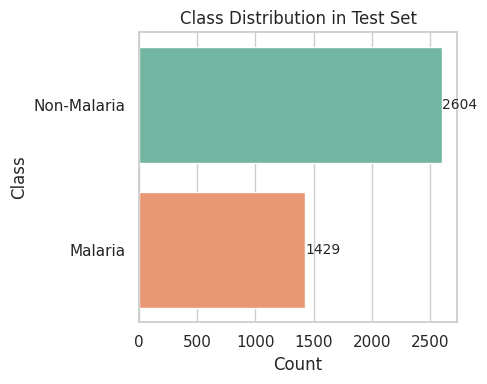

In [7]:
class_names_dict = {
    0: 'Non-Malaria',
    1: 'Malaria'
}

df_test = pd.DataFrame({'label': y_test})
df_test['class_name'] = df_test['label'].map(class_names_dict)

sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=df_test, y='class_name', palette='Set2')

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=10)

plt.title('Class Distribution in Test Set')
plt.xlabel('Count')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

In [8]:
print("Training set class distribution:", Counter(y_train))
print("Validation set class distribution:", Counter(y_val))
print("Test set class distribution:", Counter(y_test))

Training set class distribution: Counter({np.int64(0): 12234, np.int64(1): 6584})
Validation set class distribution: Counter({np.int64(0): 2617, np.int64(1): 1415})
Test set class distribution: Counter({np.int64(0): 2604, np.int64(1): 1429})


---
Bahdanau attention mechanism within a bidirectional GRU-based architecture

In [9]:
# --- PubMedBERT Setup ---
pubmedbert_model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(pubmedbert_model_name)
pubmedbert = AutoModel.from_pretrained(pubmedbert_model_name).to(device)

for param in pubmedbert.parameters():
    param.requires_grad = True

BATCH_SIZE = 32

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention Mechanism.

    This class implements the Bahdanau attention mechanism as described in the paper:
    "Neural Machine Translation by Jointly Learning to Align and Translate" by Bahdanau et al.

    Args:
        hidden_dim (int): The hidden dimension of the GRU or LSTM output.

    Attributes:
        W (nn.Linear): A linear layer for the transformation of the RNN outputs.
        v (nn.Linear): A linear layer for computing attention scores.
    """
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, rnn_outputs):
        """
        Apply the attention mechanism on the RNN outputs.

        Args:
            rnn_outputs (Tensor): The outputs of the RNN (GRU or LSTM).

        Returns:
            Tensor: The context vector computed by the attention mechanism.
        """
        score = torch.tanh(self.W(rnn_outputs))
        attn_weights = torch.softmax(self.v(score), dim=1)
        context = torch.sum(attn_weights * rnn_outputs, dim=1)
        return context

class PubMedBERT_GRU_Attention(nn.Module):
    """
    Model combining PubMedBERT embeddings, GRU layers, and Bahdanau Attention mechanism for binary classification.

    Args:
        bert_dim (int): The dimension of the PubMedBERT embeddings (usually 768).
        hidden_dim (int): The hidden dimension of the GRU layer.
        num_classes (int): The number of classes for classification (usually 2 for binary classification).
        num_layers (int): The number of layers in the GRU (default is 1).
        dropout_prob (float): Dropout probability for regularization.

    Attributes:
        gru (nn.GRU): A bidirectional GRU layer.
        attention (BahdanauAttention): The Bahdanau attention mechanism.
        fc (nn.Linear): The fully connected layer to produce the binary output.
        dropout (nn.Dropout): Dropout layer for regularization.
    """
    def __init__(self, bert_dim, hidden_dim, num_layers=1, dropout_prob=0.6, num_classes = 1):
        super(PubMedBERT_GRU_Attention, self).__init__()
        self.gru = nn.GRU(
            input_size=bert_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_outputs = pubmedbert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeds = bert_outputs.last_hidden_state
        gru_out, _ = self.gru(bert_embeds)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output  # logits

In [11]:
def count_parameters(model):
    """
    Count the number of trainable parameters in the model.
    Args:
        model: The model whose parameters are to be counted.
    Returns:
        Total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, dataloader, optimizer, criterion, device):
    """
    Train the model for one epoch, calculating loss and accuracy.
    Args:
        model: The model to train.
        dataloader: DataLoader for the training dataset.
        optimizer: Optimizer for model parameters.
        criterion: Loss function.
        device: CPU/GPU device.
    Returns:
        Average loss and accuracy for the epoch.
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        total_correct += np.sum(preds == labels.cpu().numpy())
        total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_samples
    return avg_loss, avg_accuracy

def evaluate_model(model, dataloader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        dataloader: DataLoader for validation data.
        criterion: Loss function (BCEWithLogitsLoss).
        device: CPU/GPU.
    Returns:
        Average validation loss, accuracy, F1-score.
    """
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device).unsqueeze(1)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy()
            preds = (preds > 0.5).astype(int)
            labels_cpu = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels_cpu)

    val_loss /= len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return acc, f1, val_loss

def test_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test dataset, calculating loss, accuracy, F1-score, precision, recall, and balanced accuracy.
    Args:
        model: The model to evaluate.
        test_loader: DataLoader for the test dataset.
        criterion: Loss function (BCEWithLogitsLoss).
        device: CPU/GPU device.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, recall, and precision.
    """
    model.eval()
    total_loss = 0
    total_accuracy = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            target_tensor = batch['labels'].float().to(device).unsqueeze(1)

            output = model(input_ids, attention_mask)
            loss = criterion(output, target_tensor)
            total_loss += loss.item()

            preds = torch.sigmoid(output).cpu().numpy()
            preds_bin = (preds > 0.5).astype(int)
            total_accuracy += accuracy_score(target_tensor.cpu(), preds_bin) * len(target_tensor)

            all_preds.extend(preds_bin)
            all_labels.extend(target_tensor.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    f1 = f1_score(all_labels, all_preds, zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

def get_hidden_states(model, dataloader, device):
    """
    This function extracts the hidden states from a model (either GRU or LSTM) for each sample in the dataloader.
    The hidden states are taken from the last time step of the sequence, which are typically used for classification tasks.

    Args:
        model: A PyTorch model that contains an embedding layer and either a GRU or LSTM layer.
        dataloader: A DataLoader containing batches of input data and their corresponding targets.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        hidden_states: A numpy array containing the hidden states for each sample in the dataloader.
        labels: A numpy array containing the target labels corresponding to each input sample.
    """
    model.eval()
    hidden_states, labels = [], []

    with torch.no_grad():
        for inputs, targets, _ in dataloader:
            inputs = inputs.to(device)
            embedded = model.embedding(inputs)

            if hasattr(model, "gru"):
                output, _ = model.gru(embedded)
                state = output[:, -1, :]
            elif hasattr(model, "lstm"):
                _, (state, _) = model.lstm(embedded)
                state = state[-1]
            else:
                raise ValueError("Model must contain GRU or LSTM.")

            hidden_states.append(state.cpu().numpy())
            labels.append(targets.numpy())

    return np.concatenate(hidden_states), np.concatenate(labels)

In [12]:
BERT_DIM = 768
HIDDEN_DIM = 256
DROPOUT = 0.6

model = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
print()
print(f"{count_parameters(model)} model parameters")
print()
print(model)


1708033 model parameters

PubMedBERT_GRU_Attention(
  (gru): GRU(768, 256, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


---

# 1. **Use of PubMedBERT as contextual embeddings - GRU - Bahdanau Attention**

---

PubMedBERT is a model pre-trained on a corpus of biomedical texts, and generates contextual embeddings.

In [ ]:
class PubMedBERTDataset(Dataset):
    """
    Dataset class for multi-class classification using PubMedBERT embeddings.

    Args:
        texts (list of str): A list of raw text sequences.
        labels (list of int): A list of integer labels (0-8) corresponding to each text.
        tokenizer (transformers tokenizer): A tokenizer to preprocess the text data.
        max_length (int): Maximum length for padding/truncation. Default is 400.

    Attributes:
        texts (list of str): The raw text data.
        encodings (dict): Tokenized text data with input IDs and attention masks.
        labels (Tensor): Tensor of integer labels for the classification task.
    """

    def __init__(self, texts, labels, tokenizer, max_length=400):
        self.texts = texts
        self.encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: Contains input IDs, attention masks, and the corresponding label and raw text.
        """
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        item['text'] = self.texts[idx]
        return item

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.labels)

In [ ]:
# --- Load Data ---
train_dataset = PubMedBERTDataset(X_train.tolist(), y_train, tokenizer)
val_dataset = PubMedBERTDataset(X_val.tolist(), y_val, tokenizer)
test_dataset = PubMedBERTDataset(X_test.tolist(), y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Combine the training and validation datasets (for test)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

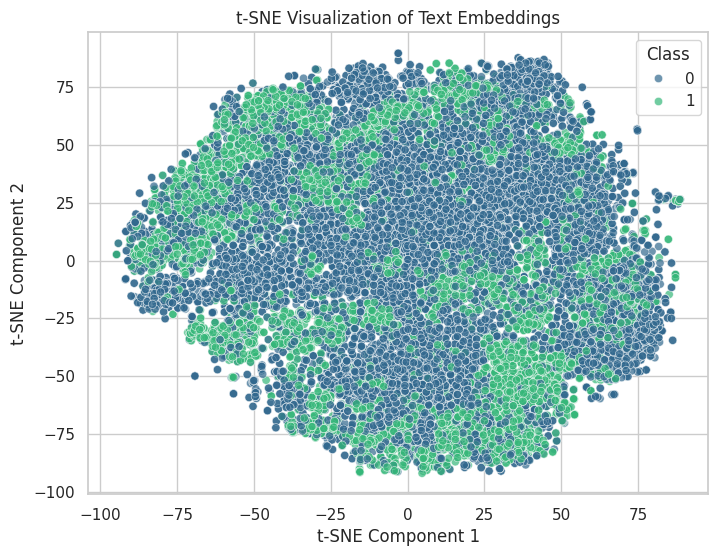

In [ ]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels']

        bert_outputs = pubmedbert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeds = bert_outputs.last_hidden_state  # [batch_size, seq_len, 768]

        # Mean pooling
        pooled = bert_embeds.mean(dim=1)  # [batch_size, 768]

        embeddings.append(pooled.cpu().numpy())
        labels.extend(labels_batch.cpu().numpy())

labels = np.array(labels)

# Stack the list of arrays into a single NumPy array
embeddings = np.vstack(embeddings)
labels = np.array(labels)

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=labels,
    palette="viridis",
    alpha=0.7
)
plt.title("t-SNE Visualization of Text Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()

---
## 1.1 **Optimisation phase**

1.1.1 Optimizer selection

In [ ]:
num_epochs = 5
learning_rate = 1e-4
weight_decay = 1e-10
criterion = nn.BCEWithLogitsLoss()

optimizers = {
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'RMSprop': optim.RMSprop,
}

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    print(model)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Pubmedbert_Attention_OptimizerSearch', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'PubMedBERT_Bi_GRU_Bahdanau_Attention',
        'hidden_dim': HIDDEN_DIM,
        'dropout_prob': DROPOUT
    })

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Opt: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[optimizer_name] = train_losses
    all_val_losses[optimizer_name] = val_losses
    all_train_accs[optimizer_name] = train_accs
    all_val_accs[optimizer_name] = val_accs

    wandb.finish()


🔹 Training with optimizer: Adam
PubMedBERT_GRU_Attention(
  (gru): GRU(768, 256, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


Total trainable parameters: 1708033


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: Adam | Epoch 1/5 - TL: 0.3566, VL: 0.2653, TA: 84.61%, VA: 89.83%, F1: 85.52%, Time: 8.49 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: Adam | Epoch 2/5 - TL: 0.2455, VL: 0.2393, TA: 90.88%, VA: 91.47%, F1: 88.28%, Time: 8.49 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: Adam | Epoch 3/5 - TL: 0.2272, VL: 0.2297, TA: 91.47%, VA: 91.54%, F1: 88.30%, Time: 8.47 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: Adam | Epoch 4/5 - TL: 0.2172, VL: 0.2294, TA: 91.93%, VA: 91.74%, F1: 88.40%, Time: 8.48 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]

Opt: Adam | Epoch 5/5 - TL: 0.2075, VL: 0.2347, TA: 92.24%, VA: 91.25%, F1: 88.09%, Time: 8.48 min


train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▇▇█▆
val_f1,▁███▇
val_loss,█▃▁▁▂
train_acc,0.92236
train_loss,0.20753
val_acc,0.91245
val_f1,0.88086
val_loss,0.23475



🔹 Training with optimizer: AdamW
PubMedBERT_GRU_Attention(
  (gru): GRU(768, 256, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


Total trainable parameters: 1708033


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: AdamW | Epoch 1/5 - TL: 0.3516, VL: 0.2567, TA: 84.75%, VA: 90.33%, F1: 86.89%, Time: 8.47 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: AdamW | Epoch 2/5 - TL: 0.2466, VL: 0.2433, TA: 90.98%, VA: 90.92%, F1: 87.77%, Time: 8.48 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: AdamW | Epoch 3/5 - TL: 0.2285, VL: 0.2336, TA: 91.60%, VA: 91.52%, F1: 88.11%, Time: 8.48 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: AdamW | Epoch 4/5 - TL: 0.2167, VL: 0.2278, TA: 91.87%, VA: 91.77%, F1: 88.66%, Time: 8.47 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]

Opt: AdamW | Epoch 5/5 - TL: 0.2096, VL: 0.2260, TA: 92.26%, VA: 92.01%, F1: 88.80%, Time: 8.47 min


train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▃▆▇█
val_f1,▁▄▅▇█
val_loss,█▅▃▁▁
train_acc,0.92257
train_loss,0.20959
val_acc,0.92014
val_f1,0.88804
val_loss,0.22597



🔹 Training with optimizer: RMSprop
PubMedBERT_GRU_Attention(
  (gru): GRU(768, 256, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


Total trainable parameters: 1708033


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: RMSprop | Epoch 1/5 - TL: 0.3346, VL: 0.2822, TA: 86.34%, VA: 89.31%, F1: 85.78%, Time: 8.47 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: RMSprop | Epoch 2/5 - TL: 0.2450, VL: 0.2356, TA: 90.87%, VA: 91.57%, F1: 88.27%, Time: 8.48 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: RMSprop | Epoch 3/5 - TL: 0.2283, VL: 0.2326, TA: 91.43%, VA: 91.49%, F1: 88.04%, Time: 8.47 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]


Opt: RMSprop | Epoch 4/5 - TL: 0.2185, VL: 0.2283, TA: 91.88%, VA: 91.62%, F1: 88.38%, Time: 8.47 min


Evaluating: 100%|██████████| 126/126 [01:26<00:00,  1.46it/s]

Opt: RMSprop | Epoch 5/5 - TL: 0.2104, VL: 0.2812, TA: 92.15%, VA: 89.11%, F1: 86.00%, Time: 8.47 min


train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▂███▁
val_f1,▁█▇█▂
val_loss,█▂▂▁█
train_acc,0.92146
train_loss,0.21036
val_acc,0.89112
val_f1,0.85997
val_loss,0.28116


1.1.2 Depth value selection

In [ ]:
depth_values = [1, 2, 3]
num_epochs = 4
learning_rate = 1e-4
weight_decay = 1e-10
criterion = nn.BCEWithLogitsLoss()

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for depth in depth_values:
    print(f"\n🔹 Training with GRU depth: {depth}")

    model = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Pubmedbert_Attention_DepthSearch',
        name=f"Depth_{depth}_run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'gru_depth': depth,
            'model': 'PubMedBERT_Bi_GRU_Bahdanau_Attention',
            'hidden_dim': HIDDEN_DIM,
            'dropout_prob': DROPOUT
        }
    )

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters (depth={depth}): {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Depth: {depth} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[f'depth_{depth}'] = train_losses
    all_val_losses[f'depth_{depth}'] = val_losses
    all_train_accs[f'depth_{depth}'] = train_accs
    all_val_accs[f'depth_{depth}'] = val_accs

    wandb.finish()


🔹 Training with GRU depth: 1


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total trainable parameters (depth=1): 1708033


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Depth: 1 | Epoch 1/4 - TL: 0.3431, VL: 0.2555, TA: 85.61%, VA: 90.15%, F1: 86.55%, Time: 8.73 min


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.42it/s]


Depth: 1 | Epoch 2/4 - TL: 0.2450, VL: 0.2381, TA: 90.95%, VA: 90.95%, F1: 87.56%, Time: 8.70 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Depth: 1 | Epoch 3/4 - TL: 0.2283, VL: 0.2288, TA: 91.45%, VA: 91.74%, F1: 88.55%, Time: 8.71 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]

Depth: 1 | Epoch 4/4 - TL: 0.2173, VL: 0.2274, TA: 91.77%, VA: 91.72%, F1: 88.55%, Time: 8.70 min


train_acc,▁▇██
train_loss,█▃▂▁
val_acc,▁▄██
val_f1,▁▅██
val_loss,█▄▁▁
train_acc,0.91769
train_loss,0.21733
val_acc,0.91716
val_f1,0.88554
val_loss,0.22742



🔹 Training with GRU depth: 2


Total trainable parameters (depth=2): 1708033


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Depth: 2 | Epoch 1/4 - TL: 0.3435, VL: 0.2567, TA: 85.34%, VA: 90.35%, F1: 86.84%, Time: 8.70 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Depth: 2 | Epoch 2/4 - TL: 0.2474, VL: 0.2468, TA: 90.77%, VA: 90.72%, F1: 87.42%, Time: 8.71 min


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]


Depth: 2 | Epoch 3/4 - TL: 0.2307, VL: 0.2368, TA: 91.33%, VA: 91.34%, F1: 88.16%, Time: 8.71 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]

Depth: 2 | Epoch 4/4 - TL: 0.2191, VL: 0.2335, TA: 91.75%, VA: 91.25%, F1: 88.01%, Time: 8.72 min


train_acc,▁▇██
train_loss,█▃▂▁
val_acc,▁▄█▇
val_f1,▁▄█▇
val_loss,█▅▂▁
train_acc,0.91753
train_loss,0.21906
val_acc,0.91245
val_f1,0.88014
val_loss,0.23352



🔹 Training with GRU depth: 3


Total trainable parameters (depth=3): 1708033


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Depth: 3 | Epoch 1/4 - TL: 0.3505, VL: 0.2558, TA: 84.98%, VA: 90.23%, F1: 86.64%, Time: 8.70 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Depth: 3 | Epoch 2/4 - TL: 0.2436, VL: 0.2376, TA: 90.83%, VA: 91.32%, F1: 88.09%, Time: 8.69 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Depth: 3 | Epoch 3/4 - TL: 0.2275, VL: 0.2328, TA: 91.53%, VA: 91.32%, F1: 88.18%, Time: 8.70 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]

Depth: 3 | Epoch 4/4 - TL: 0.2153, VL: 0.2282, TA: 91.86%, VA: 91.54%, F1: 88.07%, Time: 8.70 min


train_acc,▁▇██
train_loss,█▂▂▁
val_acc,▁▇▇█
val_f1,▁███
val_loss,█▃▂▁
train_acc,0.91859
train_loss,0.21526
val_acc,0.91543
val_f1,0.88073
val_loss,0.22821


1.3 Leanring rate value selection

In [ ]:
learning_rates = [9e-5, 3e-4, 5e-5]
num_epochs = 4
criterion = nn.BCEWithLogitsLoss()
learning_rate = 1e-4

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for lr in learning_rates:
    print(f"\n🔹 Training with learning rate: {lr}")

    model = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Pubmedbert_Attention_LRTuning',
        name=f"LR_{lr}_run",
        config={
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'gru_depth': 1,
            'model': 'PubMedBERT_Bi_GRU_Bahdanau_Attention',
            'hidden_dim': HIDDEN_DIM,
            'dropout_prob': DROPOUT
        }
    )

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters (lr={lr}): {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[f'lr_{lr}'] = train_losses
    all_val_losses[f'lr_{lr}'] = val_losses
    all_train_accs[f'lr_{lr}'] = train_accs
    all_val_accs[f'lr_{lr}'] = val_accs

    wandb.finish()


🔹 Training with learning rate: 9e-05


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total trainable parameters (lr=9e-05): 1708033


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 9e-05 | Epoch 1/4 - TL: 0.3718, VL: 0.2652, TA: 83.88%, VA: 90.10%, F1: 86.41%, Time: 9.09 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 9e-05 | Epoch 2/4 - TL: 0.2555, VL: 0.2472, TA: 90.57%, VA: 90.77%, F1: 87.23%, Time: 9.09 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 9e-05 | Epoch 3/4 - TL: 0.2400, VL: 0.2384, TA: 91.08%, VA: 91.37%, F1: 88.00%, Time: 9.09 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]

LR: 9e-05 | Epoch 4/4 - TL: 0.2305, VL: 0.2352, TA: 91.38%, VA: 91.34%, F1: 88.08%, Time: 9.09 min


train_acc,▁▇██
train_loss,█▂▁▁
val_acc,▁▅██
val_f1,▁▄██
val_loss,█▄▂▁
train_acc,0.91375
train_loss,0.23053
val_acc,0.91344
val_f1,0.88077
val_loss,0.23516



🔹 Training with learning rate: 0.0003


Total trainable parameters (lr=0.0003): 1708033


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 0.0003 | Epoch 1/4 - TL: 0.3052, VL: 0.2465, TA: 87.67%, VA: 91.07%, F1: 87.34%, Time: 9.09 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 0.0003 | Epoch 2/4 - TL: 0.2444, VL: 0.2386, TA: 91.08%, VA: 91.47%, F1: 88.23%, Time: 9.09 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 0.0003 | Epoch 3/4 - TL: 0.2357, VL: 0.2802, TA: 91.19%, VA: 90.00%, F1: 86.97%, Time: 9.09 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]

LR: 0.0003 | Epoch 4/4 - TL: 0.2292, VL: 0.2432, TA: 91.46%, VA: 90.50%, F1: 86.33%, Time: 9.09 min


train_acc,▁▇▇█
train_loss,█▂▂▁
val_acc,▆█▁▃
val_f1,▅█▃▁
val_loss,▂▁█▂
train_acc,0.9146
train_loss,0.22922
val_acc,0.90501
val_f1,0.86326
val_loss,0.24323



🔹 Training with learning rate: 5e-05


Total trainable parameters (lr=5e-05): 1708033


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 5e-05 | Epoch 1/4 - TL: 0.4382, VL: 0.3142, TA: 79.32%, VA: 87.43%, F1: 82.70%, Time: 9.08 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 5e-05 | Epoch 2/4 - TL: 0.2888, VL: 0.2694, TA: 88.77%, VA: 89.43%, F1: 85.58%, Time: 9.09 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


LR: 5e-05 | Epoch 3/4 - TL: 0.2548, VL: 0.2557, TA: 90.49%, VA: 90.20%, F1: 86.66%, Time: 9.08 min


Evaluating: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]

LR: 5e-05 | Epoch 4/4 - TL: 0.2429, VL: 0.2476, TA: 90.85%, VA: 90.72%, F1: 87.20%, Time: 9.09 min


train_acc,▁▇██
train_loss,█▃▁▁
val_acc,▁▅▇█
val_f1,▁▅▇█
val_loss,█▃▂▁
train_acc,0.90849
train_loss,0.24291
val_acc,0.90724
val_f1,0.87201
val_loss,0.2476


---
# 2. **BioBERT as contextual embeddings - GRU - Bahdanau Attention**

---

In [13]:
biobert_model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer_bioBert = AutoTokenizer.from_pretrained(biobert_model_name)
biobert = AutoModel.from_pretrained(biobert_model_name).to(device)

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Data preparation with biobert as contextual embeddings

In [14]:
class BioBERTDataset(Dataset):
    """
    PyTorch Dataset class for preparing text data for BioBERT-based classification tasks.

    This dataset takes raw text inputs and their corresponding labels, and applies
    tokenization using a provided tokenizer (e.g., BioBERT's tokenizer). It returns
    inputs in the format expected by HuggingFace Transformers models.

    Attributes:
        texts (List[str]): Original list of input text samples.
        encodings (Dict[str, torch.Tensor]): Tokenized and encoded text inputs.
        labels (torch.Tensor): Corresponding class labels for each input.

    Args:
        texts (List[str]): List of raw text samples.
        labels (List[int]): List of integer labels corresponding to each text.
        tokenizer (transformers.PreTrainedTokenizer): A HuggingFace-compatible tokenizer.
        max_length (int, optional): Maximum sequence length for tokenization. Default is 400.

    Returns:
        Dict[str, torch.Tensor]: Dictionary containing input_ids, attention_mask, labels,
                                 and the original text string.
    """
    def __init__(self, texts, labels, tokenizer, max_length=400):
        self.texts = texts
        self.encodings = tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        item['text'] = self.texts[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_dataset = BioBERTDataset(X_train.tolist(), y_train, tokenizer_bioBert)
val_dataset = BioBERTDataset(X_val.tolist(), y_val, tokenizer_bioBert)
test_dataset = BioBERTDataset(X_test.tolist(), y_test, tokenizer_bioBert)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Optional: Combine train + val if needed
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
class BioBERT_GRU_Attention(nn.Module):
    """
    A neural network model for binary classification, combining BioBERT embeddings with a bidirectional GRU and an attention mechanism.

    The model uses BioBERT to obtain contextualized word embeddings, which are then processed by a GRU layer to capture sequential dependencies.
    An attention mechanism (Bahdanau attention) is applied to focus on important sequence features before passing the output through a fully connected
    layer for classification.

    Arguments:
        encoder (nn.Module): Pre-trained BioBERT model.
        bert_dim (int): Dimension of BioBERT embeddings.
        hidden_dim (int): Hidden size of the GRU layer.
        num_layers (int, optional): Number of GRU layers (default is 1).
        dropout_prob (float, optional): Dropout rate (default is 0.6).
        num_classes (int, optional): Number of output classes (default is 1 for binary classification).

    Returns:
        torch.Tensor: Logit value for binary classification.
    """
    def __init__(self, encoder, bert_dim, hidden_dim, num_layers=1, dropout_prob=0.6, num_classes=1):
        super(BioBERT_GRU_Attention, self).__init__()
        self.encoder = encoder
        self.gru = nn.GRU(
            input_size=bert_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeds = bert_outputs.last_hidden_state
        gru_out, _ = self.gru(bert_embeds)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

In [17]:
# Define model hyperparameters
BERT_DIM = 768
HIDDEN_DIM = 256
DROPOUT = 0.6

model = BioBERT_GRU_Attention(biobert, BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
print(model)

BioBERT_GRU_Attention(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

---
# 2.1 **Optimisation phase**

2.1.1 Optimizer selection

In [ ]:
num_epochs = 4
learning_rate = 1e-4
weight_decay = 1e-10
criterion = nn.BCEWithLogitsLoss()

optimizers = {
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'RMSprop': optim.RMSprop,
}

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = BioBERT_GRU_Attention(biobert, BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
    print(model)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Biobert_Attention_OptimizerSearch', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'BioBERT_Bi_GRU_Bahdanau_Attention',
        'hidden_dim': HIDDEN_DIM,
        'dropout_prob': DROPOUT
    })

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Opt: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[optimizer_name] = train_losses
    all_val_losses[optimizer_name] = val_losses
    all_train_accs[optimizer_name] = train_accs
    all_val_accs[optimizer_name] = val_accs

    wandb.finish()


🔹 Training with optimizer: Adam
BioBERT_GRU_Attention(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total trainable parameters: 110018305


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Opt: Adam | Epoch 1/4 - TL: 0.3588, VL: 0.2746, TA: 84.89%, VA: 89.93%, F1: 86.45%, Time: 8.86 min


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]


Opt: Adam | Epoch 2/4 - TL: 0.2663, VL: 0.2529, TA: 89.83%, VA: 90.82%, F1: 87.16%, Time: 8.88 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Opt: Adam | Epoch 3/4 - TL: 0.2496, VL: 0.2411, TA: 90.61%, VA: 91.29%, F1: 88.03%, Time: 8.88 min


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]

Opt: Adam | Epoch 4/4 - TL: 0.2371, VL: 0.2380, TA: 91.17%, VA: 91.32%, F1: 88.01%, Time: 8.88 min


train_acc,▁▇▇█
train_loss,█▃▂▁
val_acc,▁▅██
val_f1,▁▄██
val_loss,█▄▂▁
train_acc,0.91168
train_loss,0.23708
val_acc,0.91319
val_f1,0.88014
val_loss,0.23801



🔹 Training with optimizer: AdamW
BioBERT_GRU_Attention(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

Total trainable parameters: 110018305


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]


Opt: AdamW | Epoch 1/4 - TL: 0.3482, VL: 0.2598, TA: 85.33%, VA: 90.50%, F1: 86.92%, Time: 8.89 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Opt: AdamW | Epoch 2/4 - TL: 0.2621, VL: 0.2544, TA: 90.31%, VA: 90.50%, F1: 87.28%, Time: 8.88 min


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]


Opt: AdamW | Epoch 3/4 - TL: 0.2466, VL: 0.2412, TA: 90.68%, VA: 90.97%, F1: 87.69%, Time: 8.89 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]

Opt: AdamW | Epoch 4/4 - TL: 0.2391, VL: 0.2345, TA: 91.17%, VA: 91.39%, F1: 88.04%, Time: 8.88 min


train_acc,▁▇▇█
train_loss,█▂▁▁
val_acc,▁▁▅█
val_f1,▁▃▆█
val_loss,█▆▃▁
train_acc,0.91173
train_loss,0.23908
val_acc,0.91394
val_f1,0.88039
val_loss,0.23447



🔹 Training with optimizer: RMSprop
BioBERT_GRU_Attention(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Layer

Total trainable parameters: 110018305


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Opt: RMSprop | Epoch 1/4 - TL: 0.3081, VL: 0.2800, TA: 88.10%, VA: 89.81%, F1: 86.40%, Time: 8.88 min


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]


Opt: RMSprop | Epoch 2/4 - TL: 0.2615, VL: 0.2495, TA: 90.33%, VA: 90.97%, F1: 87.62%, Time: 8.88 min


Evaluating: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]


Opt: RMSprop | Epoch 3/4 - TL: 0.2458, VL: 0.2408, TA: 90.84%, VA: 91.27%, F1: 87.83%, Time: 8.88 min


Evaluating: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]

Opt: RMSprop | Epoch 4/4 - TL: 0.2372, VL: 0.2349, TA: 91.13%, VA: 91.67%, F1: 88.37%, Time: 8.88 min


train_acc,▁▆▇█
train_loss,█▃▂▁
val_acc,▁▅▇█
val_f1,▁▅▆█
val_loss,█▃▂▁
train_acc,0.91126
train_loss,0.23723
val_acc,0.91667
val_f1,0.88374
val_loss,0.23489


2.1.2 Depth value selection

In [ ]:
depth_values = [1, 2, 3]
num_epochs = 4
learning_rate = 1e-4
weight_decay = 1e-10
criterion = nn.BCEWithLogitsLoss()

all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for depth in depth_values:
    print(f"\n🔹 Training with GRU depth: {depth}")

    model = BioBERT_GRU_Attention(biobert, BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Biobert_Attention_DepthSearch',
        name=f"Depth_{depth}_run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'gru_depth': depth,
            'model': 'Biobert_Bi_GRU_Bahdanau_Attention',
            'hidden_dim': HIDDEN_DIM,
            'dropout_prob': DROPOUT
        }
    )

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters (depth={depth}): {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"Depth: {depth} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[f'depth_{depth}'] = train_losses
    all_val_losses[f'depth_{depth}'] = val_losses
    all_train_accs[f'depth_{depth}'] = train_accs
    all_val_accs[f'depth_{depth}'] = val_accs

    wandb.finish()


🔹 Training with GRU depth: 1


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total trainable parameters (depth=1): 110018305


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 1 | Epoch 1/4 - TL: 0.1746, VL: 0.0937, TA: 92.66%, VA: 96.46%, F1: 97.38%, Time: 9.39 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 1 | Epoch 2/4 - TL: 0.0870, VL: 0.0885, TA: 96.61%, VA: 96.78%, F1: 97.61%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 1 | Epoch 3/4 - TL: 0.0828, VL: 0.0932, TA: 96.72%, VA: 96.57%, F1: 97.47%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]

Depth: 1 | Epoch 4/4 - TL: 0.0768, VL: 0.0967, TA: 96.96%, VA: 96.06%, F1: 97.09%, Time: 9.42 min


train_acc,▁▇██
train_loss,█▂▁▁
val_acc,▅█▆▁
val_f1,▅█▆▁
val_loss,▅▁▅█
train_acc,0.96962
train_loss,0.07677
val_acc,0.96057
val_f1,0.97088
val_loss,0.09675



🔹 Training with GRU depth: 2


Total trainable parameters (depth=2): 110018305


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 2 | Epoch 1/4 - TL: 0.1859, VL: 0.0989, TA: 91.99%, VA: 96.20%, F1: 97.20%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 2 | Epoch 2/4 - TL: 0.0870, VL: 0.0897, TA: 96.59%, VA: 96.50%, F1: 97.39%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 2 | Epoch 3/4 - TL: 0.0824, VL: 0.0980, TA: 96.68%, VA: 96.22%, F1: 97.22%, Time: 9.42 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]

Depth: 2 | Epoch 4/4 - TL: 0.0784, VL: 0.0901, TA: 96.85%, VA: 96.81%, F1: 97.63%, Time: 9.43 min


train_acc,▁███
train_loss,█▂▁▁
val_acc,▁▄▁█
val_f1,▁▄▁█
val_loss,█▁▇▁
train_acc,0.96852
train_loss,0.07845
val_acc,0.96808
val_f1,0.97627
val_loss,0.09006



🔹 Training with GRU depth: 3


Total trainable parameters (depth=3): 110018305


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 3 | Epoch 1/4 - TL: 0.1875, VL: 0.1046, TA: 92.27%, VA: 96.13%, F1: 97.16%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 3 | Epoch 2/4 - TL: 0.0877, VL: 0.0881, TA: 96.52%, VA: 96.81%, F1: 97.63%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


Depth: 3 | Epoch 3/4 - TL: 0.0816, VL: 0.0939, TA: 96.71%, VA: 96.64%, F1: 97.52%, Time: 9.42 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]

Depth: 3 | Epoch 4/4 - TL: 0.0787, VL: 0.0908, TA: 96.77%, VA: 96.48%, F1: 97.39%, Time: 9.42 min


train_acc,▁███
train_loss,█▂▁▁
val_acc,▁█▆▅
val_f1,▁█▆▄
val_loss,█▁▃▂
train_acc,0.96771
train_loss,0.07867
val_acc,0.9648
val_f1,0.97395
val_loss,0.09076


2.1.3 Learning rate value selection

In [ ]:
learning_rates = [1e-4, 5e-4]
criterion = nn.BCEWithLogitsLoss()
num_epochs = 4
all_train_losses = {}
all_val_losses = {}
all_train_accs = {}
all_val_accs = {}

for lr in learning_rates:
    print(f"\n🔹 Training with learning rate: {lr}")

    model = BioBERT_GRU_Attention(biobert, BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Biobert_Attention_LRTuning',
        name=f"LR_{lr}_run",
        config={
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'model': 'Biobert_Bi_GRU_Bahdanau_Attention',
            'hidden_dim': HIDDEN_DIM,
            'dropout_prob': DROPOUT
        }
    )

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters (lr={lr}): {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        val_acc, f1, val_loss = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        end_time = time.time()
        duration = end_time - start_time

        print(
            f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - "
            f"TL: {train_loss:.4f}, VL: {val_loss:.4f}, "
            f"TA: {train_acc:.2%}, VA: {val_acc:.2%}, F1: {f1:.2%}, "
            f"Time: {duration/60:.2f} min"
        )

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': f1,
        })

        scheduler.step(val_loss)

    all_train_losses[f'lr_{lr}'] = train_losses
    all_val_losses[f'lr_{lr}'] = val_losses
    all_train_accs[f'lr_{lr}'] = train_accs
    all_val_accs[f'lr_{lr}'] = val_accs

    wandb.finish()


🔹 Training with learning rate: 0.0001


Total trainable parameters (lr=0.0001): 110018305


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


LR: 0.0001 | Epoch 1/4 - TL: 0.1919, VL: 0.0956, TA: 91.72%, VA: 96.50%, F1: 97.42%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


LR: 0.0001 | Epoch 2/4 - TL: 0.0922, VL: 0.0891, TA: 96.54%, VA: 96.67%, F1: 97.52%, Time: 9.44 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


LR: 0.0001 | Epoch 3/4 - TL: 0.0880, VL: 0.0914, TA: 96.54%, VA: 96.64%, F1: 97.52%, Time: 9.42 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]

LR: 0.0001 | Epoch 4/4 - TL: 0.0856, VL: 0.0898, TA: 96.69%, VA: 96.48%, F1: 97.37%, Time: 9.44 min


train_acc,▁███
train_loss,█▁▁▁
val_acc,▂█▇▁
val_f1,▃██▁
val_loss,█▁▃▂
train_acc,0.96691
train_loss,0.08563
val_acc,0.9648
val_f1,0.97371
val_loss,0.08984



🔹 Training with learning rate: 0.0005


Total trainable parameters (lr=0.0005): 110018305


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


LR: 0.0005 | Epoch 1/4 - TL: 0.1309, VL: 0.1035, TA: 94.67%, VA: 95.99%, F1: 96.99%, Time: 9.44 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


LR: 0.0005 | Epoch 2/4 - TL: 0.0989, VL: 0.0915, TA: 96.21%, VA: 96.69%, F1: 97.55%, Time: 9.43 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]


LR: 0.0005 | Epoch 3/4 - TL: 0.0970, VL: 0.0987, TA: 96.25%, VA: 95.85%, F1: 96.87%, Time: 9.42 min


Evaluating: 100%|██████████| 134/134 [01:34<00:00,  1.42it/s]

LR: 0.0005 | Epoch 4/4 - TL: 0.0948, VL: 0.0913, TA: 96.33%, VA: 96.32%, F1: 97.23%, Time: 9.42 min


train_acc,▁▇██
train_loss,█▂▁▁
val_acc,▂█▁▅
val_f1,▂█▁▅
val_loss,█▁▅▁
train_acc,0.96334
train_loss,0.09484
val_acc,0.96315
val_f1,0.97232
val_loss,0.09128


---
Learning rate value is set to $ 9 \cdot 10^{-5}$.

---

# 3. **Use of Glove (300d) as word embeddings - GRU - Bahdanau Attention**

---

GloVe (Global Vectors for Word Representation) is a type of word embedding developed by the Stanford NLP Group.

In [ ]:
def tokenize(text):
    """
    Tokenizes the input text by converting it to lowercase and splitting it into words.

    Args:
        text: A string containing the text to be tokenized.

    Returns:
        A list of tokens (words) from the text.
    """
    return re.findall(r'\b\w+\b', text.lower())

In [ ]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
VOCAB_SIZE =  40000

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}

In [ ]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]
        raw_text = self.raw_text_data[idx] if self.raw_text_data is not None else None
        return input_tensor, target_tensor, raw_text

def load_glove_embeddings(glove_path, word_to_index, embedding_dim):
    """Loads GloVe embeddings and returns an embedding matrix."""
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

def custom_collate_fn(batch):
    """
    Custom collate function to combine input tensors, target tensors, and raw texts into a batch.
    Stacks inputs and targets into tensors, returns raw texts as a list.

    Args:
        batch (list): List of tuples containing input tensor, target tensor, and raw text.

    Returns:
        tuple: Stacked inputs tensor, stacked targets tensor, and list of raw texts.
    """
    inputs, targets, raw_texts = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    return inputs, targets, list(raw_texts)

In [ ]:
X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

[69, 198, 1, 1043, 229, 3496, 8380, 426, 256, 12, 60, 71, 198, 1, 189, 7299, 20588, 299, 18, 40001, 511, 4438, 2150, 2777, 268, 299, 18, 233, 726, 2306, 299, 18, 11087, 588, 71, 248, 40, 1063, 3426, 91, 300, 239, 2, 1162, 222, 350, 620, 2, 75, 463, 299, 18, 11087, 198, 1, 15482, 11, 146, 11088, 1449, 170, 4131, 20, 865, 543, 154, 1449, 91, 2016, 146, 154, 4680, 416, 96, 3079, 8228, 110, 647, 318, 543, 149, 77, 2130, 1354, 208, 1646, 252, 1449, 2576, 13943, 800, 1646, 252, 2130, 2490, 1262, 2456, 154, 477, 13317, 447, 1621, 40001, 25203, 40001, 54, 7934, 34102, 435, 3332, 40001, 368, 5486, 4680, 28763, 2193, 325, 2312, 1546, 1494, 855, 538, 325, 8229, 20, 1809, 198, 1, 2555, 213, 361, 28, 1, 118, 147, 1260, 1820, 325, 2960, 299, 18, 11087, 75, 71, 213, 361, 299, 18, 212, 558, 3146, 40, 2508, 18, 213, 361, 605, 4132, 955, 1388, 18, 3333, 7406, 9363, 54, 18978, 477, 299, 18, 2150, 20, 28, 1, 1406, 5313, 6, 6100, 4680, 477, 18, 161, 85, 856, 782, 171, 299, 18, 212, 1947, 5313, 477, 325, 45

In [ ]:
class GloVe_GRU_BahdanauAttention(nn.Module):
    """
    Model using GloVe embeddings, GRU layers, and Bahdanau Attention for classification.

    Args:
        embedding_matrix (Tensor): Pretrained GloVe embedding matrix.
        hidden_dim (int): Hidden size for the GRU.
        num_classes (int, optional): Output classes (default is 1 for binary classification).
        num_layers (int, optional): GRU depth (default is 1).
        dropout_prob (float, optional): Dropout rate (default is 0.6).
    """
    def __init__(self, embedding_matrix, hidden_dim, num_layers=1, dropout_prob=0.6, num_classes=1):
        super(GloVe_GRU_BahdanauAttention, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Using num_classes for output layer size
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Args:
            x (Tensor): Tensor of token indices (batch_size, seq_len)

        Returns:
            Tensor: Output logits for classification.
        """
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

In [ ]:
def train_epoch_glove(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch on the training data using GloVe embeddings.

    Args:
        model (nn.Module): The model to be trained.
        train_loader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the training on (CPU or CUDA).

    Returns:
        Tuple[float, float]: Average loss and accuracy over the epoch.
    """
    model.train()
    total_loss, total_accuracy = 0, 0

    for batch in train_loader:
        if len(batch) == 3:
            input_tensor, target_tensor, _ = batch
        else:
            input_tensor, target_tensor = batch

        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.float().to(device)

        optimizer.zero_grad()
        output = model(input_tensor).squeeze(1)

        loss = criterion(output, target_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        preds = (torch.sigmoid(output) >= 0.5).long()
        correct = (preds == target_tensor.long()).sum().item()
        total_accuracy += correct
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader.dataset)

    return avg_loss, avg_accuracy

def validate_epoch_glove(model, val_loader, criterion, device):
    """
    Validate the model on the validation set and compute weighted F1 and accuracy.

    Args:
        model (nn.Module): The trained model.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run validation on.

    Returns:
        Tuple[float, float, float]: Average loss, F1 score, and accuracy.
    """
    model.eval()
    total_loss, total_accuracy = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch
            else:
                input_tensor, target_tensor = batch

            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.float().to(device)

            output = model(input_tensor).squeeze(1)
            loss = criterion(output, target_tensor)

            preds = (torch.sigmoid(output) >= 0.5).long()
            correct = (preds == target_tensor.long()).sum().item()
            total_accuracy += correct
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target_tensor.long().cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_accuracy, f1, avg_loss

def test_epoch_glove(model, val_loader, criterion, device):
    """
    Validate the model and compute a complete set of metrics for multi-class classification.

    Args:
        model (nn.Module): The trained model.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run validation on.

    Returns:
        Tuple[float, float, float, float, float, float]:
            Average loss, accuracy, F1 score (weighted),
            balanced accuracy, recall (weighted), precision (weighted).
    """
    model.eval()
    total_loss, total_accuracy = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch
            else:
                input_tensor, target_tensor = batch

            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.float().to(device)

            output = model(input_tensor).squeeze(1)
            loss = criterion(output, target_tensor)

            preds = (torch.sigmoid(output) >= 0.5).long()
            correct = (preds == target_tensor.long()).sum().item()
            total_accuracy += correct
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target_tensor.long().cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = load_glove_embeddings('/content/drive/MyDrive/glove/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)

train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<ipython-input-21-cca26a6a6de7>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


---
## 3.1 **Optimisation phase**

2.1.1 Optimizer selection

In [ ]:
num_epochs = 8
learning_rate = 1e-3
loss_function = nn.BCEWithLogitsLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Comparison_gru_attention_glove300d', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


train_acc,▁
train_loss,▁
val_acc,▁
val_f1,▁
val_loss,▁
train_acc,0.89197
train_loss,0.29416
val_acc,0.9065
val_f1,0.9077
val_loss,0.2359


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Epoch 8/8 - Train Loss: 0.0472, Val Loss: 0.3818, Train ACSA: 97.99%, Val ACSA: 89.81%, Time: 0.68 min: 100%|██████████| 8/8 [05:31<00:00, 41.47s/epoch]


train_acc,▁▄▅▆▇███
train_loss,█▆▄▃▂▁▁▁
val_acc,▆█▅▂▄▂▁▁
val_f1,▆█▅▂▄▂▁▁
val_loss,▂▁▁▂▆▅▇█
train_acc,0.97986
train_loss,0.04723
val_acc,0.89807
val_f1,0.89872
val_loss,0.38183



🔹 Training with optimizer: Adam


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: Adam | Epoch 8/8 - Train Loss: 0.0417, Val Loss: 0.4202, Train ACSA: 98.23%, Val ACSA: 88.62%, Time: 0.69 min: 100%|██████████| 8/8 [05:32<00:00, 41.57s/epoch]


train_acc,▁▃▅▇████
train_loss,█▆▄▂▂▁▁▁
val_acc,▇█▅▄▃▃▄▁
val_f1,▇█▅▄▃▃▅▁
val_loss,▁▁▂▃▅▅▅█
train_acc,0.98225
train_loss,0.04173
val_acc,0.88616
val_f1,0.8849
val_loss,0.42019



🔹 Training with optimizer: AdamW


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: AdamW | Epoch 8/8 - Train Loss: 0.0467, Val Loss: 0.4505, Train ACSA: 98.11%, Val ACSA: 87.92%, Time: 0.69 min: 100%|██████████| 8/8 [05:32<00:00, 41.54s/epoch]


train_acc,▁▃▅▇▇███
train_loss,█▆▄▂▂▁▁▁
val_acc,▇█▇▆▄▅▅▁
val_f1,▇█▇▆▄▅▅▁
val_loss,▂▁▁▂▄▄▅█
train_acc,0.98114
train_loss,0.04674
val_acc,0.87922
val_f1,0.87705
val_loss,0.45049


2.1.2 Learning rate value selection

In [ ]:
learning_rates = [9e-5, 7e-5, 5e-5]
optimizer_class = optim.RMSprop
criterion = nn.BCEWithLogitsLoss()

for lr in learning_rates:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Learning rate: {lr}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay = 1e-5)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_lr_Tuning_gru_attention_glove300d',
        name=f"{optimizer_name}_lr{lr}",
        config={
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'hidden_dim': 350,
            'dropout_prob': 0.8
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | LR: {lr} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Learning rate: 9e-05


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | LR: 9e-05 | Epoch 8/8 - Train Loss: 0.1605, Val Loss: 0.2316, Train ACC: 94.02%, Val ACC: 91.25%, F1: 0.91, Time: 0.68 min: 100%|██████████| 8/8 [05:27<00:00, 40.96s/epoch]


train_acc,▁▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁
val_acc,▃▁▄▄█▁▆▄
val_f1,▂▁▄▄█▂▅▄
val_loss,█▆▃▃▁▄▁▃
train_acc,0.94022
train_loss,0.1605
val_acc,0.91245
val_f1,0.91304
val_loss,0.23155



🔹 Training with optimizer: RMSprop | Learning rate: 7e-05


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | LR: 7e-05 | Epoch 8/8 - Train Loss: 0.1780, Val Loss: 0.2255, Train ACC: 93.47%, Val ACC: 91.44%, F1: 0.92, Time: 0.68 min: 100%|██████████| 8/8 [05:28<00:00, 41.04s/epoch]


train_acc,▁▅▅▆▆▇▇█
train_loss,█▅▄▃▃▂▂▁
val_acc,▁▄▄▆██▁▇
val_f1,▂▅▄▆██▁▇
val_loss,█▄▃▁▁▁▆▁
train_acc,0.93469
train_loss,0.17796
val_acc,0.91443
val_f1,0.91501
val_loss,0.22551



🔹 Training with optimizer: RMSprop | Learning rate: 5e-05


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | LR: 5e-05 | Epoch 8/8 - Train Loss: 0.1969, Val Loss: 0.2279, Train ACC: 92.65%, Val ACC: 91.52%, F1: 0.92, Time: 0.68 min: 100%|██████████| 8/8 [05:28<00:00, 41.02s/epoch]


train_acc,▁▆▇▇▇▇██
train_loss,█▄▃▃▂▂▁▁
val_acc,▁▄▃▅▆█▃▇
val_f1,▁▄▂▅▆█▃▇
val_loss,█▅▄▃▂▂▄▁
train_acc,0.92651
train_loss,0.19689
val_acc,0.91518
val_f1,0.91546
val_loss,0.22788


2.1.3 Depth value selection

In [ ]:
learning_rate = 9e-5
depth_values = [1, 2, 3]
criterion = nn.BCEWithLogitsLoss()

for depth in depth_values:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Depth: {depth}")

    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Depth_Tuning_gru_attention_glove300d',
        name=f"{optimizer_name}_depth{depth}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'hidden_dim': 300,
            'dropout_prob': 0.9,
            'num_layers': depth
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | Depth: {depth}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | Depth: {depth} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Depth: 1


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Depth: 1 | Epoch 8/8 - Train Loss: 0.1494, Val Loss: 0.2457, Train ACC: 94.53%, Val ACC: 91.17%, F1: 0.91, Time: 0.67 min: 100%|██████████| 8/8 [05:23<00:00, 40.46s/epoch]


train_acc,▁▄▅▅▆▆▇█
train_loss,█▅▅▄▃▂▂▁
val_acc,▁▃█▆▁▄▄▃
val_f1,▁▃█▆▂▅▄▃
val_loss,█▃▁▁▃▂▁▆
train_acc,0.94532
train_loss,0.1494
val_acc,0.91171
val_f1,0.91227
val_loss,0.24567



🔹 Training with optimizer: RMSprop | Depth: 2


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Depth: 2 | Epoch 8/8 - Train Loss: 0.1522, Val Loss: 0.2358, Train ACC: 94.24%, Val ACC: 91.42%, F1: 0.91, Time: 0.68 min: 100%|██████████| 8/8 [05:25<00:00, 40.63s/epoch]


train_acc,▁▄▅▆▆▇▇█
train_loss,█▅▅▄▃▃▂▁
val_acc,▁▆█▅▇▃▆▇
val_f1,▁▆█▅▇▂▆▇
val_loss,█▂▁▃▁▇▁▂
train_acc,0.9424
train_loss,0.15223
val_acc,0.91419
val_f1,0.91448
val_loss,0.23581



🔹 Training with optimizer: RMSprop | Depth: 3


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Depth: 3 | Epoch 8/8 - Train Loss: 0.1529, Val Loss: 0.2424, Train ACC: 94.45%, Val ACC: 91.42%, F1: 0.91, Time: 0.68 min: 100%|██████████| 8/8 [05:24<00:00, 40.61s/epoch]


train_acc,▁▄▅▅▆▇██
train_loss,█▅▅▄▃▂▂▁
val_acc,▂▄▂█▅▁▅▄
val_f1,▁▃▁█▅▁▅▄
val_loss,█▅▄▁▄▅▅▇
train_acc,0.94447
train_loss,0.15292
val_acc,0.91419
val_f1,0.91435
val_loss,0.24239


2.1.4 Batch size value selection

In [ ]:
learning_rate = 1e-4
optimizer_class = optim.RMSprop
batch_sizes = [8, 16, 32]
num_epochs = 8
depth = 1
loss_function = nn.BCEWithLogitsLoss()

for BATCH_SIZE in batch_sizes:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Batch Size: {BATCH_SIZE}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    model = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Batch_Tuning_gru_attention_glove300d',
        name=f"{optimizer_name}_batch{BATCH_SIZE}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'hidden_dim': 300,
            'dropout_prob': 0.9,
            'num_layers': depth,
            'batch_size': BATCH_SIZE
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | Batch: {BATCH_SIZE}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | Batch: {BATCH_SIZE} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Batch Size: 8


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Batch: 8 | Epoch 8/8 - Train Loss: 0.0606, Val Loss: 0.1264, Train ACC: 97.99%, Val ACC: 96.36%, F1: 0.96, Time: 1.45 min: 100%|██████████| 8/8 [12:08<00:00, 91.01s/epoch]


train_acc,▁▅▆▆▇▇██
train_loss,█▄▄▃▃▂▁▁
val_acc,█▂▇▆▅▅▆▁
val_f1,█▂▇▆▅▅▆▁
val_loss,▃▁▂▄▇▆▆█
train_acc,0.97988
train_loss,0.06057
val_acc,0.96362
val_f1,0.96342
val_loss,0.1264



🔹 Training with optimizer: RMSprop | Batch Size: 16


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Batch: 16 | Epoch 8/8 - Train Loss: 0.0620, Val Loss: 0.0926, Train ACC: 97.62%, Val ACC: 96.78%, F1: 0.97, Time: 0.90 min: 100%|██████████| 8/8 [07:15<00:00, 54.40s/epoch]


train_acc,▁▅▆▇▇▇██
train_loss,█▄▃▃▂▂▁▁
val_acc,▁▆▅█▇█▇█
val_f1,▁▆▅█▇█▇█
val_loss,█▃▆▁▁▂▂▂
train_acc,0.97621
train_loss,0.06196
val_acc,0.96785
val_f1,0.96766
val_loss,0.09255



🔹 Training with optimizer: RMSprop | Batch Size: 32


GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Batch: 32 | Epoch 8/8 - Train Loss: 0.0522, Val Loss: 0.0926, Train ACC: 97.78%, Val ACC: 96.20%, F1: 0.96, Time: 0.71 min: 100%|██████████| 8/8 [05:41<00:00, 42.65s/epoch]


train_acc,▁▆▆▇▇███
train_loss,█▄▃▃▂▂▁▁
val_acc,▁▅▁▆█▁▄▂
val_f1,▁▅▁▆█▁▄▂
val_loss,▅▁▃▁▃▆▅█
train_acc,0.97782
train_loss,0.05215
val_acc,0.96198
val_f1,0.96187
val_loss,0.0926


---
Batch size value is set to 32.

---
# 4. **Use of fastText (300d) as contextual embeddings - GRU - Bahdanau Attention**

---

In [ ]:
class FastText_GRU_BahdanauAttention(nn.Module):
    """
    Model using FastText embeddings, GRU layers, and Bahdanau Attention for classification.

    Args:
        embedding_matrix (Tensor): Pretrained FastText embedding matrix.
        hidden_dim (int): Hidden size for the GRU.
        num_classes (int, optional): Output classes (default is 1 for binary classification).
        num_layers (int, optional): GRU depth (default is 1).
        dropout_prob (float, optional): Dropout rate (default is 0.6).
    """
    def __init__(self, embedding_matrix, hidden_dim, num_layers=1, dropout_prob=0.6, num_classes=1):
        super(FastText_GRU_BahdanauAttention, self).__init__()

        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Using num_classes for output layer size
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Args:
            x (Tensor): Tensor of token indices (batch_size, seq_len)

        Returns:
            Tensor: Output logits for classification.
        """
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        context = self.attention(gru_out)
        x = self.dropout(context)
        output = self.fc(x)
        return output

In [ ]:
def load_fasttext_embeddings(vec_path, word_to_index, embedding_dim=300):
    """
    Loads FastText embeddings from a .txt or .vec file and returns an embedding matrix.

    Note:
        The .txt or .vec format contains a header (num_tokens, dimension),
        followed by one word vector per line in the format: word val1 val2 ... valN.

    Args:
        vec_path (str): Path to the FastText .txt or .vec file (e.g., cc.en.300.txt or cc.en.300.vec).
        word_to_index (dict): Mapping from words to their index in the vocabulary.
        embedding_dim (int): Dimensionality of the embeddings (e.g., 300).

    Returns:
        torch.Tensor: Embedding matrix of shape (vocab_size, embedding_dim).
    """
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')

    with open(vec_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        header = f.readline()  # header contains: num_words dim
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) < embedding_dim + 1:
                continue  # skip malformed lines
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = load_fasttext_embeddings('/content/drive/MyDrive/cc.en.300.vec/cc.en.300.vec', word_to_index, EMBEDDING_DIM)

train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<ipython-input-21-cca26a6a6de7>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


---
## 4.1 **Optimisation phase**

4.1.1 Optimizer selection

In [ ]:
num_epochs = 10
learning_rate = 1e-3
loss_function = nn.BCEWithLogitsLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = FastText_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge', project='Binary_Class_Optimizer_Comparison_gru_attention_fastText300d', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Epoch 10/10 - Train Loss: 0.0329, Val Loss: 0.1471, Train ACC: 98.40%, Val ACC: 95.80%, Time: 0.71 min: 100%|██████████| 10/10 [07:08<00:00, 42.89s/epoch]


train_acc,▁▅▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▇▅█▇▇▇▁▆▂▅
val_f1,▇▅██▇▇▁▆▂▅
val_loss,▁▂▁▂▂▄█▇▇▆
train_acc,0.98396
train_loss,0.0329
val_acc,0.95799
val_f1,0.95778
val_loss,0.14709



🔹 Training with optimizer: Adam


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: Adam | Epoch 10/10 - Train Loss: 0.0399, Val Loss: 0.1544, Train ACC: 98.23%, Val ACC: 95.89%, Time: 0.72 min: 100%|██████████| 10/10 [07:14<00:00, 43.43s/epoch]


train_acc,▁▆▇▇▇█████
train_loss,█▄▃▃▃▂▁▁▁▁
val_acc,█▇█▅▇▅▆▁▂▅
val_f1,█▇▇▅▇▄▆▁▂▅
val_loss,▁▁▃▃▂▃▇▆██
train_acc,0.9823
train_loss,0.03985
val_acc,0.95893
val_f1,0.95867
val_loss,0.15435



🔹 Training with optimizer: AdamW


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: AdamW | Epoch 10/10 - Train Loss: 0.0338, Val Loss: 0.1322, Train ACC: 98.36%, Val ACC: 95.54%, Time: 0.73 min: 100%|██████████| 10/10 [07:17<00:00, 43.74s/epoch]


train_acc,▁▆▇▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▄▆▆█▅▅▆▂▄▁
val_f1,▄▆▆█▅▄▆▂▄▁
val_loss,▂▂▂▁▄▅▄██▅
train_acc,0.98355
train_loss,0.03383
val_acc,0.95541
val_f1,0.95544
val_loss,0.13221


4.1.2 Learning rate value selection

In [ ]:
learning_rates = [9e-4, 1e-3, 3e-4]
optimizer_class = optim.RMSprop
criterion = nn.BCEWithLogitsLoss()

for lr in learning_rates:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Learning rate: {lr}")

    model = FastText_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay = 1e-5)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Multi_Class_lr_Tuning_gru_attention_fastText300d',
        name=f"{optimizer_name}_lr{lr}",
        config={
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'hidden_dim': 350,
            'dropout_prob': 0.8
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | LR: {lr} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Learning rate: 0.0009


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | LR: 0.0009 | Epoch 10/10 - Train Loss: 0.0444, Val Loss: 0.1269, Train ACC: 97.90%, Val ACC: 96.15%, F1: 0.96, Time: 0.72 min: 100%|██████████| 10/10 [07:10<00:00, 43.01s/epoch]


train_acc,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▅██▇█▇▁▅▇▆
val_f1,▅██▇█▇▁▅▇▅
val_loss,▂▁▁▂▃▂▅▆▇█
train_acc,0.97903
train_loss,0.04445
val_acc,0.96151
val_f1,0.96125
val_loss,0.12685



🔹 Training with optimizer: RMSprop | Learning rate: 0.001


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | LR: 0.001 | Epoch 10/10 - Train Loss: 0.0472, Val Loss: 0.1174, Train ACC: 97.92%, Val ACC: 96.48%, F1: 0.96, Time: 0.72 min: 100%|██████████| 10/10 [07:11<00:00, 43.12s/epoch]


train_acc,▁▅▅▆▇▇████
train_loss,█▄▄▃▃▂▂▂▁▁
val_acc,▂▅▅█▇█▆▇▁▆
val_f1,▂▅▅█▇█▆▆▁▆
val_loss,▅▁▂▃▁▂▃▆▅█
train_acc,0.97918
train_loss,0.04721
val_acc,0.9648
val_f1,0.96455
val_loss,0.11735



🔹 Training with optimizer: RMSprop | Learning rate: 0.0003


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | LR: 0.0003 | Epoch 10/10 - Train Loss: 0.0406, Val Loss: 0.1156, Train ACC: 98.20%, Val ACC: 95.73%, F1: 0.96, Time: 0.72 min: 100%|██████████| 10/10 [07:10<00:00, 43.07s/epoch]


train_acc,▁▅▇▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▆█▇▆▁▆▂▆▄▂
val_f1,▆█▇▆▁▆▂▆▄▂
val_loss,▃▂▁▂▆▇█▄▅▇
train_acc,0.98205
train_loss,0.04063
val_acc,0.95729
val_f1,0.95719
val_loss,0.1156


4.1.3 Depth value selection

In [ ]:
learning_rate = 1e-3
depth_values = [1, 2, 3]
criterion = nn.BCEWithLogitsLoss()

for depth in depth_values:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Depth: {depth}")

    model = FastText_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Depth_Tuning_gru_attention_fastText300d',
        name=f"{optimizer_name}_depth{depth}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'hidden_dim': 300,
            'dropout_prob': 0.9,
            'num_layers': depth
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | Depth: {depth}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | Depth: {depth} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Depth: 1


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Depth: 1 | Epoch 10/10 - Train Loss: 0.0325, Val Loss: 0.1641, Train ACC: 98.43%, Val ACC: 95.47%, F1: 0.95, Time: 0.71 min: 100%|██████████| 10/10 [07:07<00:00, 42.71s/epoch]


train_acc,▁▅▆▆▇▇█▇▇█
train_loss,█▄▄▃▂▂▂▂▂▁
val_acc,▇▇█▇▄▁▆▅▄▃
val_f1,▇▇█▇▄▁▆▅▄▃
val_loss,▁▂▂▃▄▅▅▇▆█
train_acc,0.98431
train_loss,0.03255
val_acc,0.95471
val_f1,0.95471
val_loss,0.16414



🔹 Training with optimizer: RMSprop | Depth: 2


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Depth: 2 | Epoch 10/10 - Train Loss: 0.0297, Val Loss: 0.1479, Train ACC: 98.43%, Val ACC: 94.93%, F1: 0.95, Time: 0.71 min: 100%|██████████| 10/10 [07:07<00:00, 42.71s/epoch]


train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▃▂▂▁▁▁▁
val_acc,▅▆█▆▄▆▇▅▃▁
val_f1,▅▆█▆▄▆▇▅▃▁
val_loss,▂▂▁▁▂▃▅█▆▅
train_acc,0.98426
train_loss,0.02973
val_acc,0.94931
val_f1,0.94956
val_loss,0.14788



🔹 Training with optimizer: RMSprop | Depth: 3


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Depth: 3 | Epoch 10/10 - Train Loss: 0.0308, Val Loss: 0.1976, Train ACC: 98.48%, Val ACC: 95.31%, F1: 0.95, Time: 0.71 min: 100%|██████████| 10/10 [07:06<00:00, 42.68s/epoch]


train_acc,▁▅▆▇▇▇████
train_loss,█▅▃▃▂▂▁▁▁▁
val_acc,▇█▆▅▅▅▁▂▂▂
val_f1,▇█▆▅▅▅▁▂▂▂
val_loss,▁▁▂▅▄▄▆▆▆█
train_acc,0.98481
train_loss,0.03084
val_acc,0.95306
val_f1,0.95305
val_loss,0.19764


4.1.4 Batch size value selection

In [ ]:
num_epochs = 7
learning_rate = 1e-3
optimizer_class = optim.RMSprop
batch_sizes = [8, 32, 64]
depth = 1
loss_function = nn.BCEWithLogitsLoss()

for BATCH_SIZE in batch_sizes:
    optimizer_name = "RMSprop"
    print(f"\n🔹 Training with optimizer: {optimizer_name} | Batch Size: {BATCH_SIZE}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    model = FastText_GRU_BahdanauAttention(embedding_matrix=embedding_matrix, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_Batch_Tuning_gru_attention_fastText300d',
        name=f"{optimizer_name}_batch{BATCH_SIZE}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'hidden_dim': 300,
            'dropout_prob': 0.9,
            'num_layers': depth,
            'batch_size': BATCH_SIZE
        }
    )

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name} | Batch: {BATCH_SIZE}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch_glove(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_acc, val_f1, val_loss = validate_epoch_glove(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Optimizer: {optimizer_name} | Batch: {BATCH_SIZE} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"F1: {val_f1:.2f}, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop | Batch Size: 8


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Batch: 8 | Epoch 7/7 - Train Loss: 0.0809, Val Loss: 0.5830, Train ACC: 97.66%, Val ACC: 88.19%, F1: 0.88, Time: 1.35 min: 100%|██████████| 7/7 [09:31<00:00, 81.69s/epoch]


train_acc,▁▃▅▆▇██
train_loss,█▆▄▃▂▁▁
val_acc,██▇▆▁▆▂
val_f1,██▇▆▁▆▂
val_loss,▁▂▃▂▄▆█
train_acc,0.97656
train_loss,0.0809
val_acc,0.88194
val_f1,0.88347
val_loss,0.58298



🔹 Training with optimizer: RMSprop | Batch Size: 32


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Batch: 32 | Epoch 7/7 - Train Loss: 0.0663, Val Loss: 0.3257, Train ACC: 97.47%, Val ACC: 90.05%, F1: 0.90, Time: 0.69 min: 100%|██████████| 7/7 [04:51<00:00, 41.64s/epoch]


train_acc,▁▄▇▇▇██
train_loss,█▆▃▂▂▁▁
val_acc,▁██████
val_f1,▁██████
val_loss,█▂▁▁▁▂▃
train_acc,0.97471
train_loss,0.06626
val_acc,0.90055
val_f1,0.90029
val_loss,0.3257



🔹 Training with optimizer: RMSprop | Batch Size: 64


FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201


Optimizer: RMSprop | Batch: 64 | Epoch 7/7 - Train Loss: 0.0554, Val Loss: 0.3713, Train ACC: 97.86%, Val ACC: 90.18%, F1: 0.90, Time: 0.64 min: 100%|██████████| 7/7 [04:27<00:00, 38.19s/epoch]


train_acc,▁▆▆▇███
train_loss,█▄▃▂▂▁▁
val_acc,██▇▆▄▁▅
val_f1,██▇▆▄▁▅
val_loss,▁▁▁▃▆█▇
train_acc,0.97864
train_loss,0.05537
val_acc,0.90179
val_f1,0.90221
val_loss,0.37128


---
# 4. **Test phase**

---

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def reinitialize_weights(model):
    """Reinitializes the model's weights by calling reset_parameters() for each layer that supports it."""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def plot_confusion_matrix(ax, y_true, y_pred, num_classes=2):
    """Plots a confusion matrix as a heatmap.
    Args:
        ax (matplotlib.axes.Axes): The axes on which to plot the confusion matrix.
        y_true (list or array): The true class labels for the test set.
        y_pred (list or array): The predicted class labels for the test set.
        num_classes (int): The number of unique classes in the dataset.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes), ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

def evaluate_and_analyze_glove(model, test_loader, device, num_classes=2):
    """
    Evaluates a GloVe-based model on the test dataset and analyzes prediction performance.

    Args:
        model (nn.Module): Trained PyTorch model using GloVe embeddings.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform evaluation on (CPU or GPU).

    Returns:
        df_results (pd.DataFrame): Classification report with precision, recall, F1-score, and support.
        df_correct (pd.DataFrame): Samples that were predicted correctly with their info.
        df_wrong (pd.DataFrame): Samples that were predicted incorrectly with their info.
        all_labels (list): Ground truth labels for all test samples.
        all_probs (list): Predicted class probabilities for all test samples.
    """
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []
    all_indices = []

    top_correct = []
    top_wrong = []

    with torch.no_grad():
        for idx, (inputs, labels, raw_text) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs).squeeze(1)
                preds = (probs >= 0.5).long()
            else:
                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_indices.extend(range(len(labels)))

            correct_indices = (preds == labels).nonzero(as_tuple=True)[0]
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for correct_idx in correct_indices:
                top_correct.append({
                    'index': correct_idx.item(),
                    'true_label': labels[correct_idx].item(),
                    'predicted_label': preds[correct_idx].item(),
                    'probability': probs[correct_idx].cpu().item(),
                    'text': raw_text[correct_idx.item()] if raw_text is not None else None
                })

            for wrong_idx in wrong_indices:
                top_wrong.append({
                    'index': wrong_idx.item(),
                    'true_label': labels[wrong_idx].item(),
                    'predicted_label': preds[wrong_idx].item(),
                    'probability': probs[wrong_idx].cpu().item(),
                    'text': raw_text[wrong_idx.item()] if raw_text is not None else None
                })

    df_correct = pd.DataFrame(top_correct)
    df_wrong = pd.DataFrame(top_wrong)

    class_report = classification_report(all_labels, all_preds, output_dict=True)
    df_results = pd.DataFrame(class_report).transpose()

    return df_results, df_correct, df_wrong, all_labels, all_preds, all_probs

def evaluate_and_analyze_pubMedBert(model, test_loader, device):
    """
    Evaluates a BERT-based model (e.g., PubMedBERT) on the test dataset and performs detailed analysis.

    Args:
        model (nn.Module): Trained BERT-based model.
        test_loader (DataLoader): DataLoader that yields dictionary-style batches with input_ids, attention_mask, etc.
        device (torch.device): Device to perform evaluation on (CPU or GPU).

    Returns:
        df_results (pd.DataFrame): DataFrame with per-class success and failure rates.
        df_wrong (pd.DataFrame): Samples that were predicted incorrectly with full metadata.
        df_correct (pd.DataFrame): Samples that were predicted correctly with full metadata.
        all_labels (list): Ground truth labels for all test samples.
        all_probs (list): Predicted class probabilities for all test samples.
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    all_texts = []

    top_correct = []
    top_wrong = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            texts = batch['text']

            outputs = model(input_ids, attention_mask)

            if outputs.shape[1] == 1:  # Binary classification
                probs = torch.sigmoid(outputs).squeeze(1)
                preds = (probs >= 0.5).long()
            else:
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                probs = probs[:, 1]  # Prob of class 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_texts.extend(texts)

            correct_indices = (preds == labels).nonzero(as_tuple=True)[0]
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in correct_indices:
                top_correct.append({
                    "index": idx.item(),
                    "true_label": labels[idx].item(),
                    "predicted_label": preds[idx].item(),
                    "probability": probs[idx].item(),
                    "text": texts[idx]
                })

            for idx in wrong_indices:
                top_wrong.append({
                    "index": idx.item(),
                    "true_label": labels[idx].item(),
                    "predicted_label": preds[idx].item(),
                    "probability": probs[idx].item(),
                    "text": texts[idx]
                })

    df_correct = pd.DataFrame(top_correct)
    df_wrong = pd.DataFrame(top_wrong)
    df_results = pd.DataFrame(classification_report(all_labels, all_preds, output_dict=True)).transpose()

    return df_results, df_correct, df_wrong, all_labels, all_preds, all_probs

def plot_wrong_distributions(wrong_samples, num_classes=2):
    """Plots the distribution of wrong predictions for each class."""
    class_counts_wrong = defaultdict(int)

    for sample in wrong_samples:
        true_label = sample['true_label']
        class_counts_wrong[true_label] += 1

    class_labels = sorted(class_counts_wrong.keys())
    counts = [class_counts_wrong[label] for label in class_labels]
    colors = sns.color_palette("husl", len(class_labels))

    class_names = [f"Class {label}" for label in class_labels]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    plt.barh(class_names, counts, color=colors)
    plt.xlabel('Number of Wrong Predictions')
    plt.ylabel('Classes')
    plt.title('Distribution of Wrong Predictions for Each Class')

    for i, (count, name) in enumerate(zip(counts, class_names)):
        plt.text(count, i, str(count), ha='left', va='center')

    plt.show()

In [ ]:
embedding_matrix_glove = load_glove_embeddings('/content/drive/MyDrive/glove/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)
embedding_matrix_fastText = load_fasttext_embeddings('/content/drive/MyDrive/cc.en.300.vec/cc.en.300.vec', word_to_index, EMBEDDING_DIM)

models = {
    "GloVe_GRU_BahdanauAttention": GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix_glove, hidden_dim=300, num_layers=1, dropout_prob=0.9).to(device),
    "FastText_GRU_BahdanauAttention": FastText_GRU_BahdanauAttention(embedding_matrix=embedding_matrix_fastText, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device),
    "PubMedBERT_GRU_Attention": PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device),
    "BioBERT_GRU_Attention": BioBERT_GRU_Attention(biobert, BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
}

optimizers = {
    "GloVe_GRU_BahdanauAttention": optim.RMSprop(models["GloVe_GRU_BahdanauAttention"].parameters(), lr=1e-4, weight_decay=1e-10),
    "FastText_GRU_BahdanauAttention": optim.RMSprop(models["FastText_GRU_BahdanauAttention"].parameters(), lr=1e-3, weight_decay=1e-10),
    "PubMedBERT_GRU_Attention": optim.AdamW(models["PubMedBERT_GRU_Attention"].parameters(), lr=1e-4, weight_decay=1e-10),
    "BioBERT_GRU_Attention": optim.RMSprop(models["BioBERT_GRU_Attention"].parameters(), lr=1e-4, weight_decay=1e-10)
}

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
loss_gap_ratio = 1.25
ax_accuracy_gap = 5
num_epochs = 6
BATCH_SIZE = 16
model_metrics = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...\n")
    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    reinitialize_weights(model)
    optimizer = optimizers[model_name]
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    if "PubMedBERT" in model_name:
        train_dataset = PubMedBERTDataset(X_train.tolist(), y_train, tokenizer)
        val_dataset = PubMedBERTDataset(X_val.tolist(), y_val, tokenizer)
        test_dataset = PubMedBERTDataset(X_test.tolist(), y_test, tokenizer)
    elif "BioBERT" in model_name:
        train_dataset = BioBERTDataset(X_train.tolist(), y_train, tokenizer_bioBert)
        val_dataset = BioBERTDataset(X_val.tolist(), y_val, tokenizer_bioBert)
        test_dataset = BioBERTDataset(X_test.tolist(), y_test, tokenizer_bioBert)
    else:
        train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
        val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
        test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary-Class-Models-Train-Test-Bio-PubMedBERT-Glove-FastText300d-Attention',
        name=f"{model_name}_Training",
        config={
            'learning_rate': 9e-5,
            'num_epochs': num_epochs,
            'num_layers': 1
        }
    )

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []

    saved_once = False
    with tqdm(total=num_epochs, desc=f"Training {model_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            if "PubMedBERT" in model_name or "BioBERT" in model_name:
                train_loss, train_acc = train_model(model, combined_loader, optimizer, loss_function, device)
                test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_model(
                    model, test_loader, loss_function, device)
            else:
                train_loss, train_acc = train_epoch_glove(model, combined_loader, optimizer, loss_function, device)
                test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_epoch_glove(
                    model, test_loader, loss_function, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            test_f1s.append(test_f1)
            test_balanced_accs.append(test_balanced_acc)
            test_recalls.append(test_recall)
            test_precisions.append(test_precision)

            wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "test_balanced_acc": test_balanced_acc,
                "test_recall": test_recall,
                "test_precision": test_precision
            })

            if (test_loss > train_loss * loss_gap_ratio or train_acc - test_acc > ax_accuracy_gap / 100) and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_early_stop.pth")
                saved_once = True
                break

            if epoch == num_epochs - 1 and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_final.pth")

            pbar.update(1)

        epoch_table = wandb.Table(columns=["Epoch", "Train Loss", "Test Loss", "Train Acc", "Test Acc", "F1", "Balanced Acc", "Recall", "Precision"])
        for epoch in range(len(train_losses)):
            epoch_table.add_data(epoch + 1, train_losses[epoch], test_losses[epoch], train_accuracies[epoch],
                                 test_accuracies[epoch], test_f1s[epoch], test_balanced_accs[epoch],
                                 test_recalls[epoch], test_precisions[epoch])
        wandb.log({f"{model_name}_Metrics_Table": epoch_table})

        model_metrics[model_name] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
            "test_f1s": test_f1s,
            "test_balanced_accs": test_balanced_accs,
            "test_recalls": test_recalls,
            "test_precisions": test_precisions
        }


Training GloVe_GRU_BahdanauAttention model...

GloVe_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=600, out_features=300, bias=True)
    (v): Linear(in_features=300, out_features=1, bias=False)
  )
  (fc): Linear(in_features=600, out_features=1, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
)
Total trainable parameters: 13265401


<ipython-input-20-cca26a6a6de7>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training GloVe_GRU_BahdanauAttention:  67%|██████▋   | 4/6 [04:57<02:28, 74.44s/epoch]


Training FastText_GRU_BahdanauAttention model...

FastText_GRU_BahdanauAttention(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=700, out_features=350, bias=True)
    (v): Linear(in_features=350, out_features=1, bias=False)
  )
  (fc): Linear(in_features=700, out_features=1, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)
Total trainable parameters: 13616201



<ipython-input-20-cca26a6a6de7>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


test_acc,▁▄▅▄█
test_balanced_acc,▁█▇▆█
test_f1,▁▄▆▄█
test_loss,█▂▁▄▃
test_precision,▁▅▆▄█
test_recall,▁▄▅▄█
train_acc,▁▅▆▇█
train_loss,█▃▂▂▁
test_acc,0.96503
test_balanced_acc,0.95778
test_f1,0.96495


Training FastText_GRU_BahdanauAttention:  50%|█████     | 3/6 [04:27<04:27, 89.02s/epoch]



Training PubMedBERT_GRU_Attention model...

PubMedBERT_GRU_Attention(
  (gru): GRU(768, 256, batch_first=True, bidirectional=True)
  (attention): BahdanauAttention(
    (W): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)
Total trainable parameters: 1708033


test_acc,▁▁█▁
test_balanced_acc,▅▁█▇
test_f1,▁▁█▁
test_loss,▃▁▃█
test_precision,▁▂█▁
test_recall,▁▁█▁
train_acc,▁▅▇█
train_loss,█▄▂▁
test_acc,0.96926
test_balanced_acc,0.96015
test_f1,0.9691


Training PubMedBERT_GRU_Attention: 100%|██████████| 6/6 [1:08:50<00:00, 688.34s/epoch]



Training BioBERT_GRU_Attention model...

BioBERT_GRU_Attention(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

test_acc,▇▄▄█▆▁
test_balanced_acc,██▆▅▁▁
test_f1,▇▄▄█▆▁
test_loss,█▄▇▁▃▃
test_precision,▇█▆▄▁▃
test_recall,▃▁▃▆█▄
train_acc,▁▇▇███
train_loss,█▃▂▂▁▁
test_acc,0.96902
test_balanced_acc,0.96092
test_f1,0.97723


Training BioBERT_GRU_Attention: 100%|██████████| 6/6 [1:10:22<00:00, 703.77s/epoch]


In [ ]:
# Function to get the correct metrics for early stopping
def get_last_saved_metrics(metrics, saved_once):
    if saved_once:
        # Return the last saved epoch's metrics
        return {
            "f1": metrics["test_f1s"][-1],
            "balanced_acc": metrics["test_balanced_accs"][-1],
            "recall": metrics["test_recalls"][-1],
            "precision": metrics["test_precisions"][-1]
        }
    else:
        # If no early stopping, we just take the last epoch's metrics
        return {
            "f1": metrics["test_f1s"][-1],
            "balanced_acc": metrics["test_balanced_accs"][-1],
            "recall": metrics["test_recalls"][-1],
            "precision": metrics["test_precisions"][-1]
        }

In [ ]:
# Initialize dictionary to store results
summary_metrics = {
    "Model": [],
    "F1 Score": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

for model_name, metrics in model_metrics.items():
    saved_once = False
    for epoch_idx, test_loss in enumerate(metrics["test_losses"]):
        if test_loss > metrics["train_losses"][epoch_idx] * loss_gap_ratio or metrics["train_accuracies"][epoch_idx] - metrics["test_accuracies"][epoch_idx] > ax_accuracy_gap / 100:
            saved_once = True
            break

    saved_metrics = get_last_saved_metrics(metrics, saved_once)

    summary_metrics["Model"].append(model_name)
    summary_metrics["F1 Score"].append(saved_metrics["f1"])
    summary_metrics["Balanced Accuracy"].append(saved_metrics["balanced_acc"])
    summary_metrics["Recall"].append(saved_metrics["recall"])
    summary_metrics["Precision"].append(saved_metrics["precision"])

df_summary = pd.DataFrame(summary_metrics)
df_melted = df_summary.melt(id_vars="Model", var_name="Metric", value_name="Score")

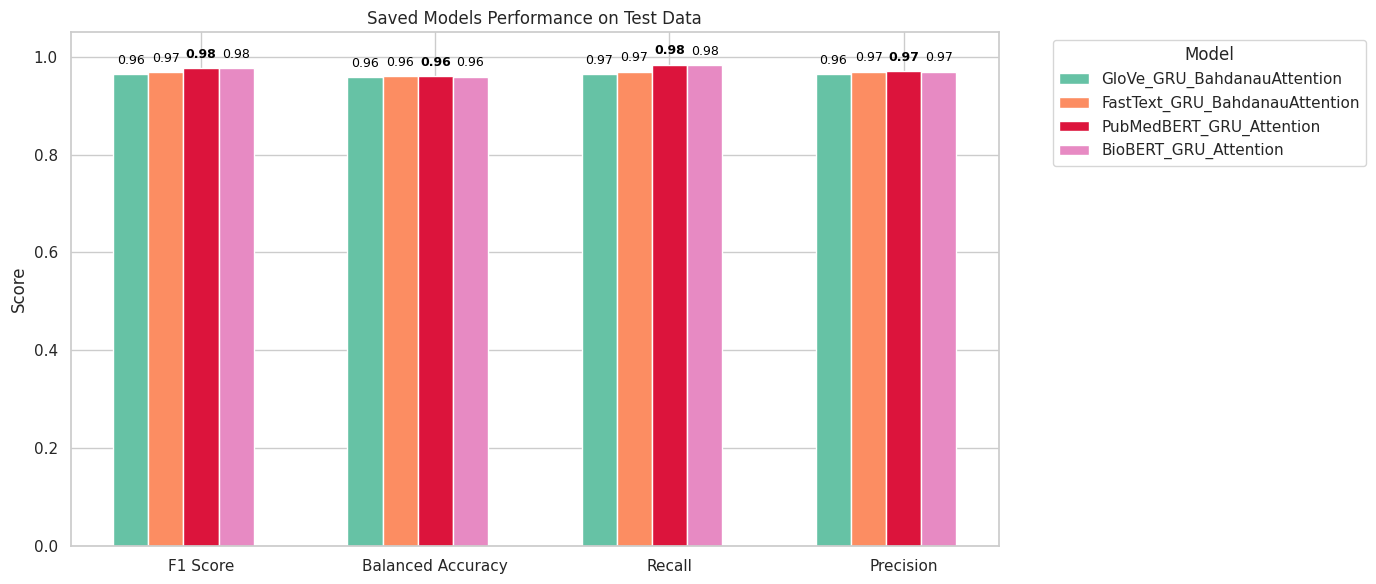

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 6))

models = df_summary["Model"].tolist()
palette = sns.color_palette("Set2", len(models))

for i, metric in enumerate(df_melted["Metric"].unique()):
    data = df_melted[df_melted["Metric"] == metric]
    max_score = data["Score"].max()

    for j, (index, row) in enumerate(data.iterrows()):
        color = "crimson" if row["Score"] == max_score else palette[models.index(row["Model"])]
        bar = ax.bar(
            x=i - 0.3 + j * (0.6 / len(models)),
            height=row["Score"],
            width=0.6 / len(models),
            color=color,
            label=row["Model"] if i == 0 else "",
        )
        ax.text(
            x=bar[0].get_x() + bar[0].get_width() / 2,
            y=row["Score"] + 0.015,
            s=f"{row['Score']:.2f}",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            fontweight='bold' if row["Score"] == max_score else 'normal'
        )

ax.set_xticks(range(len(df_melted["Metric"].unique())))
ax.set_xticklabels(df_melted["Metric"].unique())
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Saved Models Performance on Test Data")
ax.grid(True, axis='y')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("best_model_performance_comparison_all_values.png")
plt.show()

In [ ]:
# Define checkpoint paths
checkpoint_paths = {
    "GloVe_GRU_BahdanauAttention": "/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/GloVe_GRU_BahdanauAttention_early_stop.pth",
    "FastText_GRU_BahdanauAttention": "/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/FastText_GRU_BahdanauAttention_early_stop.pth",
    "PubMedBERT_GRU_Attention": "/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/PubMedBERT_GRU_Attention_final.pth",
    "BioBERT_GRU_Attention": "/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/BioBERT_GRU_Attention_final.pth"
}

models = [
    GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix_glove, hidden_dim=300, num_layers=1, dropout_prob=0.9).to(device),
    FastText_GRU_BahdanauAttention(embedding_matrix=embedding_matrix_fastText, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device),
    PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device),
    BioBERT_GRU_Attention(biobert, BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
]

model_names = [
    "GloVe_GRU_BahdanauAttention",
    "FastText_GRU_BahdanauAttention",
    "PubMedBERT_GRU_Attention",
    "BioBERT_GRU_Attention"
]

inference_times = {}

# Define test loader based on model type
for model_name, model in zip(model_names, models):
    print(f"\nLoading model weights for {model_name}")

    model.load_state_dict(torch.load(checkpoint_paths[model_name]))
    model.eval()

    if "PubMedBERT" in model_name:
        test_dataset = PubMedBERTDataset(X_test.tolist(), y_test, tokenizer)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    elif "BioBERT" in model_name:
        test_dataset = BioBERTDataset(X_test.tolist(), y_test, tokenizer_bioBert)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    else:  # For GloVe and FastText models
        test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Start inference for the current model
    start_time = time.time()

    with torch.no_grad():
        for batch in test_loader:
            if "PubMedBERT" in model_name or "BioBERT" in model_name:
                inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
                _ = model(**inputs)
            else:
                inputs, _, raw_text = batch
                inputs = inputs.to(device)
                _ = model(inputs)

    inference_duration = time.time() - start_time
    inference_minutes = inference_duration / 60
    inference_times[model_name] = inference_minutes

    print(f"Inference time for {model_name}: {inference_minutes:.2f} minutes")


Loading model weights for GloVe_GRU_BahdanauAttention


<ipython-input-21-cca26a6a6de7>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


Inference time for GloVe_GRU_BahdanauAttention: 0.05 minutes

Loading model weights for FastText_GRU_BahdanauAttention
Inference time for FastText_GRU_BahdanauAttention: 0.04 minutes

Loading model weights for PubMedBERT_GRU_Attention
Inference time for PubMedBERT_GRU_Attention: 1.67 minutes

Loading model weights for BioBERT_GRU_Attention
Inference time for BioBERT_GRU_Attention: 1.68 minutes


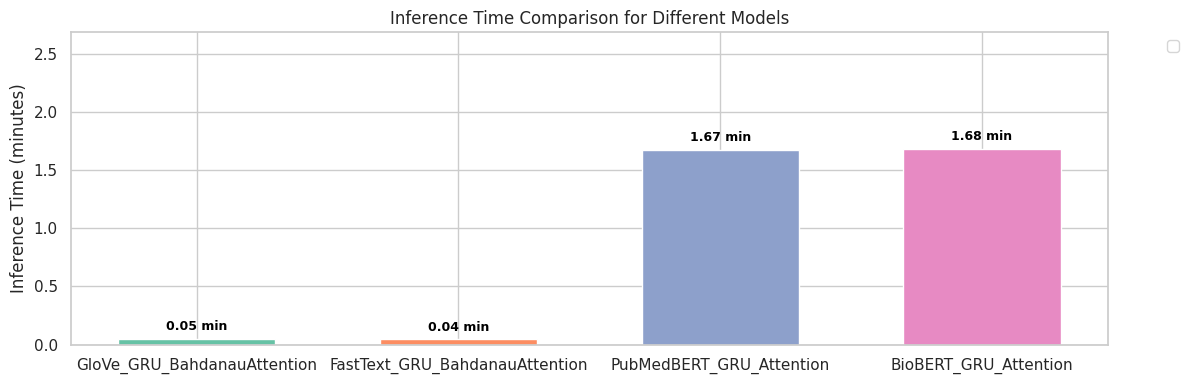

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 4))

models = list(inference_times.keys())
inference_time_values = list(inference_times.values())

palette = sns.color_palette("Set2", len(models))
bars = ax.bar(
    range(len(models)),
    inference_time_values,
    width=0.6,
    color=palette,
    tick_label=models
)

for i, bar in enumerate(bars):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        f"{bar.get_height():.2f} min",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        fontweight='bold'
    )

ax.set_ylim(0, max(inference_time_values) + 1)
ax.set_ylabel("Inference Time (minutes)")
ax.set_title("Inference Time Comparison for Different Models")
ax.grid(True, axis='y')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title=None, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("inference_time_comparison.png")
plt.show()

---
The PubMedBERT-based model with Bidirectional GRU and Bahdanau Attention consistently outperforms the GloVe-based model with Bidirectional GRU and Bahdanau Attention across all key metrics, though by a small margin of 0.01.

This performance gain, while subtle, demonstrates that contextual embeddings like PubMedBERT provide a more nuanced and contextual understanding of biomedical text compared to traditional word embeddings like GloVe.

Furthermore, the consistency across F1 Score, Precision, Recall, and Balanced Accuracy suggests that the PubMedBERT-based model with Bidirectional GRU and Bahdanau Attention delivers more stable and generalizable predictions, which is especially valuable when dealing with class-imbalanced biomedical datasets

In [ ]:
test_dataset_glove = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)
test_dataset_pubMed = PubMedBERTDataset(X_test.tolist(), y_test, tokenizer)
test_dataset_bio = BioBERTDataset(X_test.tolist(), y_test, tokenizer_bioBert)

test_loader_glove = DataLoader(test_dataset_glove, batch_size=BATCH_SIZE, shuffle=False)
test_loader_pubMed = DataLoader(test_dataset_pubMed, batch_size=BATCH_SIZE, shuffle=False)
test_loader_bio = DataLoader(test_dataset_bio, batch_size=BATCH_SIZE, shuffle=False)

model_glove = GloVe_GRU_BahdanauAttention(embedding_matrix=embedding_matrix_glove, hidden_dim=300, num_layers=1, dropout_prob=0.9).to(device)
model_glove.load_state_dict(torch.load("/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/GloVe_GRU_BahdanauAttention_early_stop.pth"))

model_fasttext = FastText_GRU_BahdanauAttention(embedding_matrix=embedding_matrix_fastText, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
model_fasttext.load_state_dict(torch.load("/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/FastText_GRU_BahdanauAttention_early_stop.pth"))

model_pubMedBert = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device)
model_pubMedBert.load_state_dict(torch.load("/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/PubMedBERT_GRU_Attention_final.pth"))

model_bioBert = BioBERT_GRU_Attention(biobert, BERT_DIM, HIDDEN_DIM, dropout_prob=DROPOUT).to(device)
model_bioBert.load_state_dict(torch.load("/content/drive/MyDrive/bi-class-models-bahd-gru-lstm-no-resampling/BioBERT_GRU_Attention_final.pth"))

<ipython-input-21-cca26a6a6de7>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


<All keys matched successfully>

In [ ]:
# Evaluate models
df_results_glove, df_correct_glove, df_wrong_glove, all_labels_glove, all_pred_glove, all_probs_glove = evaluate_and_analyze_glove(model_glove, test_loader_glove, device)
df_results_fasttext, df_correct_fasttext, df_wrong_fasttext, all_labels_fasttext, all_pred_fasttext, all_probs_fasttext = evaluate_and_analyze_glove(model_fasttext, test_loader_glove, device)
df_results_pubMedBert, df_correct_pubMedBert, df_wrong_pubMedBert, all_labels_pubMedBert, all_pred_pubMedBert, all_probs_pubMedBert = evaluate_and_analyze_pubMedBert(model_pubMedBert, test_loader_pubMed, device)
df_results_bioBert, df_correct_bioBert, df_wrong_bioBert, all_labels_bioBert, all_pred_bioBert, all_probs_bioBert = evaluate_and_analyze_pubMedBert(model_bioBert, test_loader_bio, device)

In [ ]:
df_wrong_bioBert.head(3)

,index,true_label,predicted_label,probability,text
0,8,1,0,0.478630,tropical infectious disease inflict unacceptab...
1,29,0,1,0.662938,background objective mosquito vector key threa...
2,2,1,0,0.446246,background endometrial cancer ec common gyneco...


In [ ]:
df_correct_glove.tail(3)

,index,true_label,predicted_label,probability,text
4109,2,0,0,0.000200,introduction diversity plasmodium falciparum g...
4110,3,0,0,0.043119,prevalence distribution african alphavirus chi...
4111,4,1,1,0.999730,"alzheimer disease ad remains incurable, highli..."


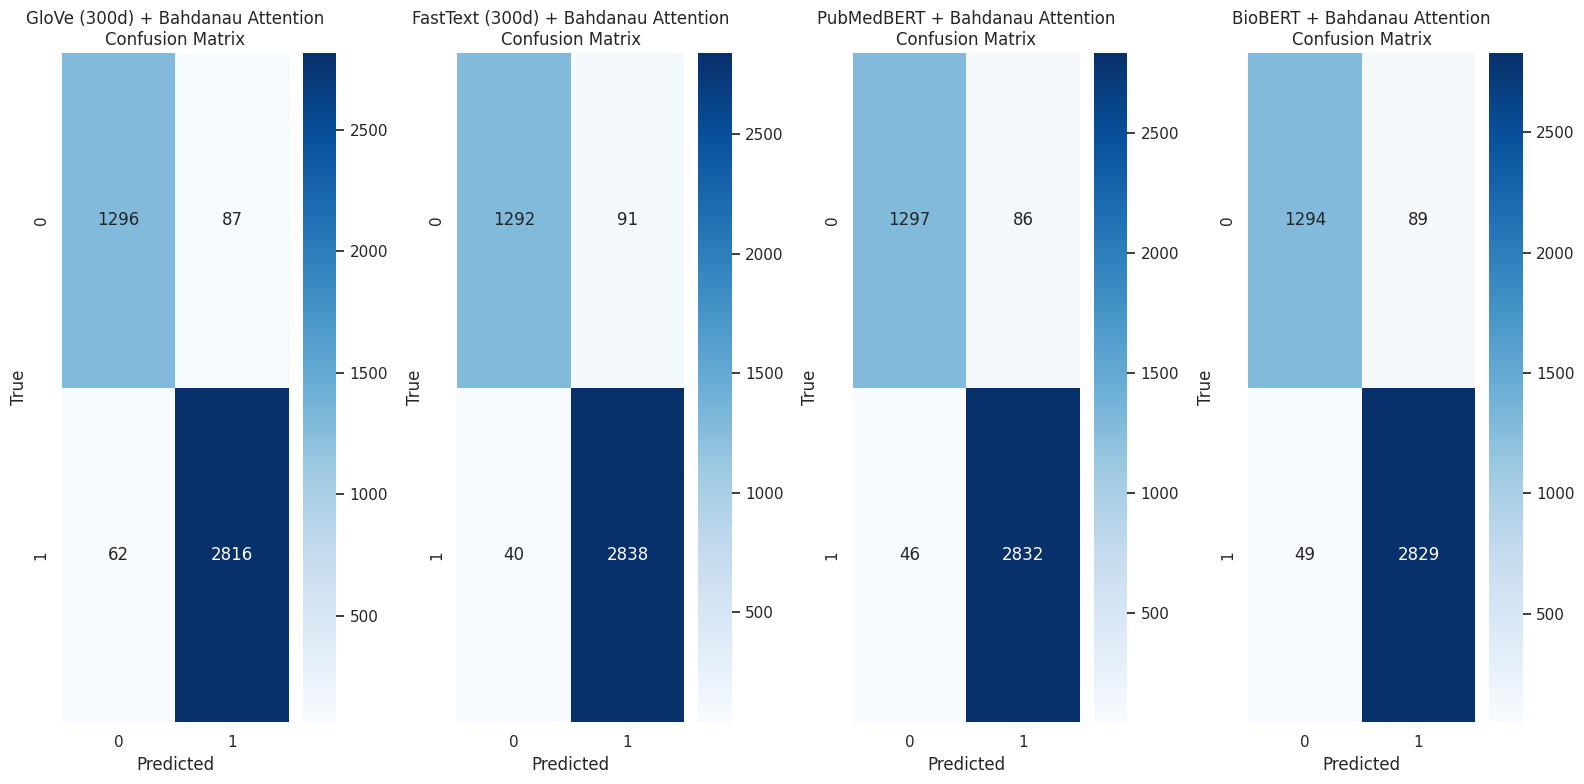

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 4, figsize=(16, 8))

plot_confusion_matrix(axes[0], all_labels_glove, all_pred_glove, num_classes = 2)
axes[0].set_title("GloVe (300d) + Bahdanau Attention\nConfusion Matrix")

plot_confusion_matrix(axes[1], all_labels_fasttext, all_pred_fasttext, num_classes = 2)
axes[1].set_title("FastText (300d) + Bahdanau Attention\nConfusion Matrix")

plot_confusion_matrix(axes[2], all_labels_pubMedBert, all_pred_pubMedBert, num_classes = 2)
axes[2].set_title("PubMedBERT + Bahdanau Attention\nConfusion Matrix")

plot_confusion_matrix(axes[3], all_labels_bioBert, all_pred_bioBert, num_classes = 2)
axes[3].set_title("BioBERT + Bahdanau Attention\nConfusion Matrix")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Convert labels and predicted probabilities to numpy arrays
y_true_glove = np.array(all_labels_glove)
y_scores_glove = np.array(all_probs_glove)

y_true_fastText = np.array(all_labels_fasttext)
y_scores_fastText = np.array(all_probs_fasttext)

y_true_pubMedBert = np.array(all_labels_pubMedBert)
y_scores_pubMedBert = np.array(all_probs_pubMedBert)

y_true_bioBert = np.array(all_labels_bioBert)
y_scores_bioBert = np.array(all_probs_bioBert)

# Compute ROC and AUC
fpr_glove, tpr_glove, _ = roc_curve(y_true_glove, y_scores_glove)
roc_auc_glove = auc(fpr_glove, tpr_glove)

fpr_fastText, tpr_fastText, _ = roc_curve(y_true_fastText, y_scores_fastText)
roc_auc_fastText = auc(fpr_fastText, tpr_fastText)

fpr_pubMedBert, tpr_pubMedBert, _ = roc_curve(y_true_pubMedBert, y_scores_pubMedBert)
roc_auc_pubMedBert = auc(fpr_pubMedBert, tpr_pubMedBert)

fpr_bioBert, tpr_bioBert, _ = roc_curve(y_true_bioBert, y_scores_bioBert)
roc_auc_bioBert = auc(fpr_bioBert, tpr_bioBert)

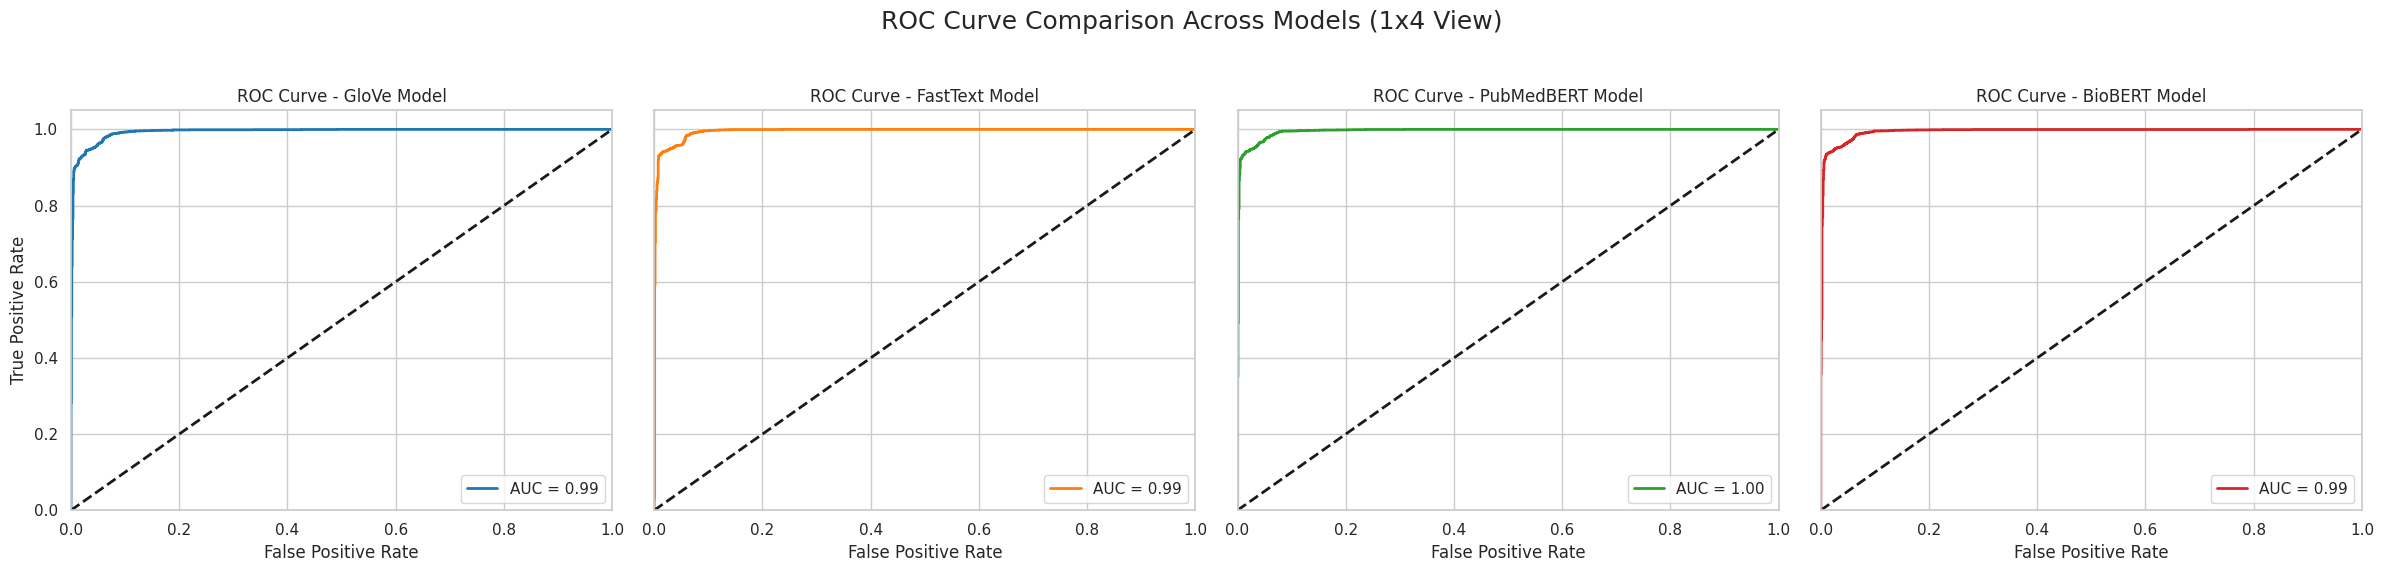

In [ ]:
sns.set(style="whitegrid")

# Set up 1 row × 4 columns
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)

# --- GloVe ---
axes[0].plot(fpr_glove, tpr_glove, lw=2, label=f'AUC = {roc_auc_glove:.2f}', color='tab:blue')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - GloVe Model')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# --- FastText ---
axes[1].plot(fpr_fastText, tpr_fastText, lw=2, label=f'AUC = {roc_auc_fastText:.2f}', color='tab:orange')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_title('ROC Curve - FastText Model')
axes[1].legend(loc='lower right')
axes[1].grid(True)

# --- PubMedBERT ---
axes[2].plot(fpr_pubMedBert, tpr_pubMedBert, lw=2, label=f'AUC = {roc_auc_pubMedBert:.2f}', color='tab:green')
axes[2].plot([0, 1], [0, 1], 'k--', lw=2)
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_title('ROC Curve - PubMedBERT Model')
axes[2].legend(loc='lower right')
axes[2].grid(True)

# --- BioBERT ---
axes[3].plot(fpr_bioBert, tpr_bioBert, lw=2, label=f'AUC = {roc_auc_bioBert:.2f}', color='tab:red')
axes[3].plot([0, 1], [0, 1], 'k--', lw=2)
axes[3].set_xlim([0.0, 1.0])
axes[3].set_ylim([0.0, 1.05])
axes[3].set_xlabel('False Positive Rate')
axes[3].set_title('ROC Curve - BioBERT Model')
axes[3].legend(loc='lower right')
axes[3].grid(True)

# Final layout adjustments
fig.suptitle('ROC Curve Comparison Across Models (1x4 View)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle
plt.show()

### ROC Curve Interpretation

These are ROC (Receiver Operating Characteristic) curves for a multi-class classification task. The closer each curve is to the top-left corner, the better the model is at distinguishing between classes. The diagonal line represents random guessing—so curves well above this line indicate strong classification performance.

Both models—GloVe + Bahdanau Attention and PubMedBERT + Bahdanau Attention—show excellent results across all classes. However, PubMedBERT exhibits slightly more consistent and higher AUC scores, indicating a modest performance advantage.

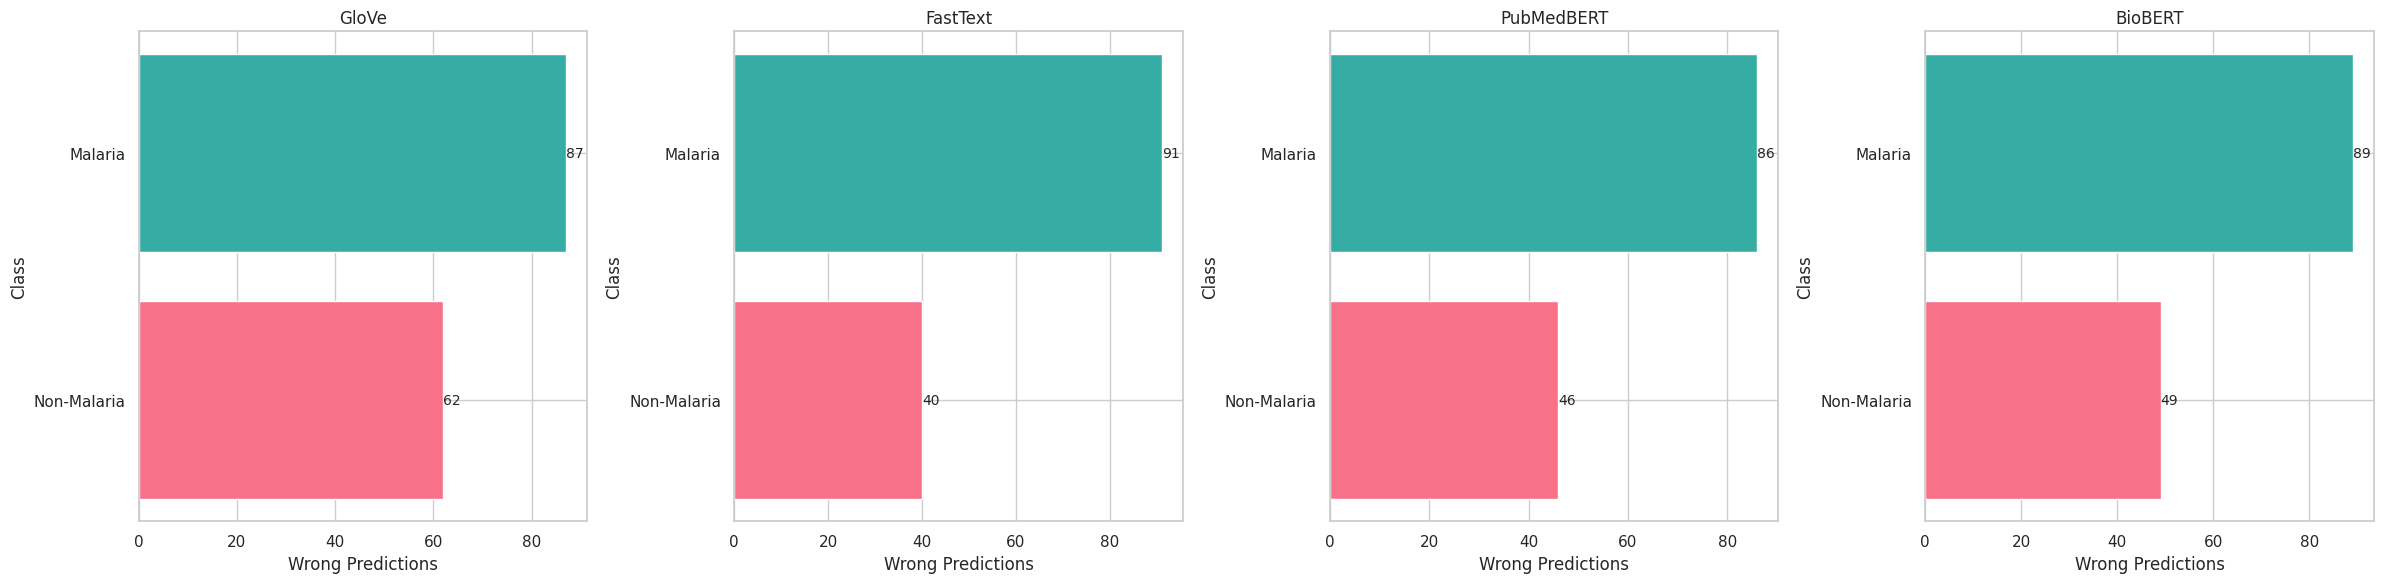

In [ ]:
wrong_df_glove = pd.DataFrame({'predictions': all_pred_glove, 'labels': all_labels_glove})
wrong_df_glove['wrong'] = wrong_df_glove['predictions'] != wrong_df_glove['labels']

wrong_df_fasttext = pd.DataFrame({'predictions': all_pred_fasttext, 'labels': all_labels_fasttext})
wrong_df_fasttext['wrong'] = wrong_df_fasttext['predictions'] != wrong_df_fasttext['labels']

wrong_df_pubMedBert = pd.DataFrame({'predictions': all_pred_pubMedBert, 'labels': all_labels_pubMedBert})
wrong_df_pubMedBert['wrong'] = wrong_df_pubMedBert['predictions'] != wrong_df_pubMedBert['labels']

wrong_df_bioBert = pd.DataFrame({'predictions': all_pred_bioBert, 'labels': all_labels_bioBert})
wrong_df_bioBert['wrong'] = wrong_df_bioBert['predictions'] != wrong_df_bioBert['labels']

# Function to count wrong predictions per class
def get_wrong_counts(df):
    wrong_class_counts = defaultdict(int)
    for _, row in df.iterrows():
        if row['wrong']:
            wrong_class_counts[row['predictions']] += 1
    wrong_class_labels = sorted(wrong_class_counts.keys())
    wrong_counts = [wrong_class_counts[label] for label in wrong_class_labels]
    return wrong_class_labels, wrong_counts

wrong_class_labels_glove, wrong_counts_glove = get_wrong_counts(wrong_df_glove)
wrong_class_labels_fasttext, wrong_counts_fasttext = get_wrong_counts(wrong_df_fasttext)
wrong_class_labels_pubMedBert, wrong_counts_pubMedBert = get_wrong_counts(wrong_df_pubMedBert)
wrong_class_labels_bioBert, wrong_counts_bioBert = get_wrong_counts(wrong_df_bioBert)

# Visualization
sns.set(style="whitegrid", palette="muted", font_scale=1.0001)
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# GloVe
wrong_colors_glove = sns.color_palette("husl", len(wrong_class_labels_glove))
class_names_glove = [class_names_dict[label] for label in wrong_class_labels_glove]
axes[0].barh(class_names_glove, wrong_counts_glove, color=wrong_colors_glove)
axes[0].set_title('GloVe')

# FastText
wrong_colors_fasttext = sns.color_palette("husl", len(wrong_class_labels_fasttext))
class_names_fasttext = [class_names_dict[label] for label in wrong_class_labels_fasttext]
axes[1].barh(class_names_fasttext, wrong_counts_fasttext, color=wrong_colors_fasttext)
axes[1].set_title('FastText')

# PubMedBERT
wrong_colors_pubMedBert = sns.color_palette("husl", len(wrong_class_labels_pubMedBert))
class_names_pubMedBert = [class_names_dict[label] for label in wrong_class_labels_pubMedBert]
axes[2].barh(class_names_pubMedBert, wrong_counts_pubMedBert, color=wrong_colors_pubMedBert)
axes[2].set_title('PubMedBERT')

# BioBERT
wrong_colors_bioBert = sns.color_palette("husl", len(wrong_class_labels_bioBert))
class_names_bioBert = [class_names_dict[label] for label in wrong_class_labels_bioBert]
axes[3].barh(class_names_bioBert, wrong_counts_bioBert, color=wrong_colors_bioBert)
axes[3].set_title('BioBERT')

# Formatting plots
for ax, counts, names in zip(axes,
                             [wrong_counts_glove, wrong_counts_fasttext, wrong_counts_pubMedBert, wrong_counts_bioBert],
                             [class_names_glove, class_names_fasttext, class_names_pubMedBert, class_names_bioBert]):
    ax.set_xlabel('Wrong Predictions')
    ax.set_ylabel('Class')
    for i, count in enumerate(counts):
        ax.text(count, i, str(count), ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

---

**Summary**


Using PubMedBert enables to achieve lower misclassification rates in 5 out of 9 disease classes, especially for:

Leprosy: 45% fewer wrong predictions

Cholera: 64% fewer wrong predictions

Leukemia: 75% fewer wrong predictions

Using GloVe enables to perform slightly better in Parkinson, Ebola, and Tuberculosis.

Tuberculosis remains the most challenging class for both models, especially PubMedBert.


---

# **Model Performance Comparison**

| **Model**                               | **Input Type**        | **Accuracy** | **Balanced Accuracy** | **F1 Score** | **Recall** | **Precision** |
|-----------------------------------------|-----------------------|--------------|-----------------------|--------------|------------|---------------|
| **GRU**                                 | No embeddings          | 87.74%       | 88.00%                | 87.78%       | 87.74%     | 88.00%        |
| **LSTM**                                | No embeddings          | 88.13%       | 88.46%                | 88.36%       | 88.13%     | 88.88%        |
| **CNN + GRU**                           | No embeddings          | 86.77%       | 87.09%                | 87.11%       | 86.77%     | 88.35%        |
| **CNN + LSTM**                          | No embeddings          | 88.13%       | 88.40%                | 88.36%       | 88.13%     | 89.34%        |
| **GRU**                                 | GloVe (300d)           | **92.17%**   | **92.36%**            | **92.15%**   | **92.17%** | **92.21%**    |
| **LSTM**                                | GloVe (300d)           | 88.34%       | 88.82%                | 88.41%       | 88.34%     | 89.07%        |
| **CNN + GRU**                           | GloVe (300d)           | 89.70%       | 89.86%                | 89.65%       | 89.70%     | 89.74%        |
| **CNN + LSTM**                          | GloVe (300d)           | 88.88%       | 89.13%                | 88.97%       | 88.88%     | 89.60%        |
| **Bidirectional GRU + Bahdanau Attention** | **PubMedBERT**         | **92.00%**       | **92.28%**            | **92.01%**       | **92.00%**     | **92.06%**        |
| **Bidirectional GRU + Bahdanau Attention** | GloVe (300d)           | **90.63%**       | **90.86%**                | **90.64%**       | **90.63%**     | **90.67%**        |

---
Given the imbalance in the dataset, we are now tackling this issue by implementing techniques such as SMOTE, weighted training, and Borderline-SMOTE. We will evaluate their impact by measuring improvements in model performance and the balance of the data distribution.

In biomedical text classification, datasets often exhibit significant class imbalances, with certain categories—such as rare diseases or specific biomedical events—being underrepresented compared to others. This imbalance can result in biased model performance, where deep learning models tend to prioritize the majority class, thereby neglecting important but rare information. For example, in a dataset where the number of samples in the 'Non-Malaria' class significantly exceeds those in the 'Malaria' class, the model may struggle to effectively learn and predict the minority class.

To address this challenge, we incorporate class weights during the selection phase of our pipeline. This approach helps mitigate the impact of class imbalance by giving more importance to the underrepresented class, ensuring a more balanced and fair model performance.

---

---

In [18]:
from google.colab import files
upload = files.upload()

Saving PubMedBERT_GRU_Attention_final.pth to PubMedBERT_GRU_Attention_final.pth


In [19]:
model = PubMedBERT_GRU_Attention(BERT_DIM, HIDDEN_DIM, num_layers=1, dropout_prob=DROPOUT).to(device)

In [20]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for batch in combined_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels']

        bert_outputs = pubmedbert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeds = bert_outputs.last_hidden_state  # [batch_size, seq_len, 768]

        # Mean pooling
        pooled = bert_embeds.mean(dim=1)  # [batch_size, 768]

        embeddings.append(pooled.cpu().numpy())
        labels.extend(labels_batch.cpu().numpy())

labels = np.array(labels)

# Stack the list of arrays into a single NumPy array
embeddings = np.vstack(embeddings)
labels = np.array(labels)

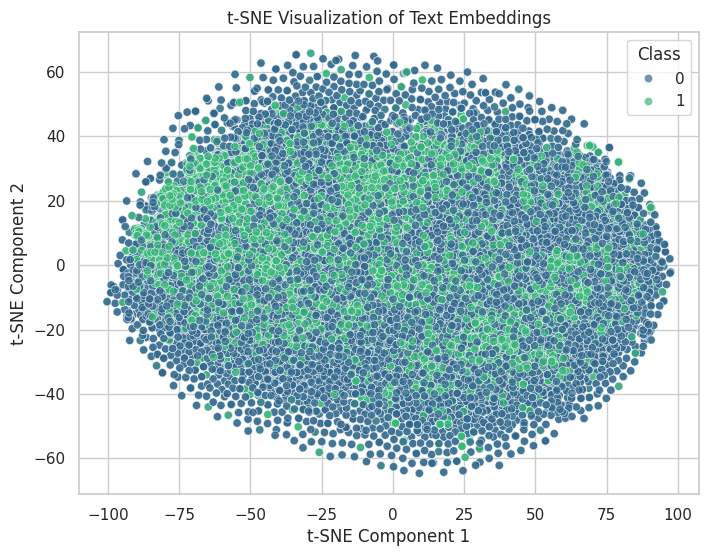

In [21]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=labels,
    palette="viridis",
    alpha=0.7
)
plt.title("t-SNE Visualization of Text Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()